# Galaxy Wearables Stress Analysis - Pipeline

Analiza danych stresu z Galaxy Wearables na podstawie sygnałów PPG (HRV), EDA, ACC i TEMP.

## Pipeline - zgodnie z propozycją (9 kroków):

1. **Wczytanie danych** - sygnały HR, ACC, BVP/PPG, TEMP dla każdego uczestnika, sprawdzenie próbek i braków
2. **Segmentacja** - Event.csv → segmenty wg sesji (TSST, SSST) lub równomierne okna 60s, każdy segment z etykietą
3. **Wyciąganie cech** - HRV (RMSSD, SDNN, pNN50, MEAN_RR), ACC (aktywność), TEMP (średnia, SD)
4. **Weryfikacja danych** - brakujące/inf/nan → mediana, rozkład klas, sprawdzenie uczestników
5. **LOSO Split** - Leave-One-Subject-Out: jeden uczestnik test, reszta train
6. **Normalizacja** - StandardScaler/RobustScaler (fit na train, transform na test - brak data leakage)
7. **Analiza eksploracyjna** - rozkłady cech per sesja/uczestnik, boxplot, korelacje
8. **Modelowanie** - Logistic Regression, Random Forest, Gradient Boosting z LOSO evaluation
9. **Analiza wyników** - feature importance, ROC curves, confusion matrix, wnioski

## Sygnały:
- **PPG** → HRV features (RMSSD, SDNN/SDRR, pNN50, LF/HF, HR_mean)
- **EDA/GSR** → tonic/phasic, mean, max, std, peak_count
- **ACC** → aktywność (mean, std, energia ruchu - opcjonalnie)
- **Temperatura skóry** → dodatkowy feature (jeśli dostępna)

## Etykiety:
- **baseline** → no stress (0)
- **task / conversation / math_task** → stress (1)
- **recovery** → no stress (0) lub osobna klasa


## KROK 1: Import bibliotek i konfiguracja


In [50]:
# 🔹 IMPORTS I KONFIGURACJA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

# Signal processing
from scipy import signal
from scipy.signal import butter, filtfilt, find_peaks
from scipy.stats import skew, kurtosis
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d

# ML
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# XGBoost (opcjonalnie)
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("⚠️ XGBoost nie jest zainstalowany. Zainstaluj: pip install xgboost")

# SHAP dla interpretacji (opcjonalnie)
try:
    import shap
    HAS_SHAP = True
except ImportError:
    HAS_SHAP = False
    print("⚠️ SHAP nie jest zainstalowany. Zainstaluj: pip install shap")

# Ustawienia
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Parametry segmentacji
WINDOW_SIZE_SECONDS = 60  # Okno 60 sekund
OVERLAP_SECONDS = 0  # Bez overlap (lub 30 dla 50% overlap)

# Częstotliwość próbkowania (dostosuj do Galaxy Wearables)
TARGET_FS = 32  # Hz (standardowa dla wearable)

print("✅ Importy zakończone")
print(f"   WINDOW_SIZE: {WINDOW_SIZE_SECONDS}s")
print(f"   TARGET_FS: {TARGET_FS} Hz")


✅ Importy zakończone
   WINDOW_SIZE: 60s
   TARGET_FS: 32 Hz


## KROK 2: Funkcje pomocnicze - HRV i EDA feature extraction


In [51]:
# Funkcje do wyciągania cech HRV i EDA

def calculate_hrv_features(rri_values, fs=1.0):
    # Oblicza klasyczne cechy HRV z interwałów R-R
    if len(rri_values) < 10:
        return {}
    
    rri_values = np.array(rri_values, dtype=float)
    rri_values = rri_values[~np.isnan(rri_values)]
    rri_values = rri_values[rri_values > 0]
    
    if len(rri_values) < 10:
        return {}
    
    features = {}
    
    # Podstawowe statystyki czasowe
    features['MEAN_RR'] = np.mean(rri_values)
    features['SDRR'] = np.std(rri_values)
    features['RMSSD'] = np.sqrt(np.mean(np.diff(rri_values)**2))
    
    # pNN50
    diff_rri = np.diff(rri_values)
    pnn50 = np.sum(np.abs(diff_rri) > 50) / len(diff_rri) * 100
    features['pNN50'] = pnn50
    
    # HR (tętno)
    features['HR'] = 60000 / features['MEAN_RR'] if features['MEAN_RR'] > 0 else 0
    
    # Analiza częstotliwościowa (LF/HF)
    try:
        time_points = np.cumsum(rri_values) / 1000  # Sekundy
        time_interp = np.arange(time_points[0], time_points[-1], 1/fs)
        
        if len(time_interp) > 10:
            f_interp = interp1d(time_points, rri_values, kind='linear', fill_value='extrapolate')
            rri_interp = f_interp(time_interp)
            
            fft_vals = fft(rri_interp - np.mean(rri_interp))
            freqs = fftfreq(len(rri_interp), 1/fs)
            power = np.abs(fft_vals)**2
            
            vlf_band = (freqs >= 0.0033) & (freqs < 0.04)
            lf_band = (freqs >= 0.04) & (freqs < 0.15)
            hf_band = (freqs >= 0.15) & (freqs < 0.4)
            
            vlf_power = np.trapz(power[vlf_band], freqs[vlf_band])
            lf_power = np.trapz(power[lf_band], freqs[lf_band])
            hf_power = np.trapz(power[hf_band], freqs[hf_band])
            total_power = vlf_power + lf_power + hf_power
            
            features['VLF'] = vlf_power
            features['LF'] = lf_power
            features['HF'] = hf_power
            features['TP'] = total_power
            features['LF_HF'] = lf_power / hf_power if hf_power > 0 else 0
            features['HF_LF'] = hf_power / lf_power if lf_power > 0 else 0
            features['LF_norm'] = (lf_power / total_power) * 100 if total_power > 0 else 0
            features['HF_norm'] = (hf_power / total_power) * 100 if total_power > 0 else 0
        else:
            features['VLF'] = 0
            features['LF'] = 0
            features['HF'] = 0
            features['TP'] = 0
            features['LF_HF'] = 0
            features['HF_LF'] = 0
            features['LF_norm'] = 0
            features['HF_norm'] = 0
    except:
        features['VLF'] = 0
        features['LF'] = 0
        features['HF'] = 0
        features['TP'] = 0
        features['LF_HF'] = 0
        features['HF_LF'] = 0
        features['LF_norm'] = 0
        features['HF_norm'] = 0
    
    features['SD1'] = features['RMSSD'] / np.sqrt(2)
    features['SD2'] = np.sqrt(2 * features['SDRR']**2 - features['SD1']**2) if features['SDRR'] > 0 else 0
    features['SKEW'] = skew(rri_values)
    features['KURT'] = kurtosis(rri_values)
    
    return features


def calculate_eda_features(eda_signal):
    # Oblicza cechy EDA (Electrodermal Activity) z sygnału EDA
    if len(eda_signal) < 10:
        return {}
    
    eda_signal = np.array(eda_signal, dtype=float)
    eda_signal = eda_signal[~np.isnan(eda_signal)]
    
    if len(eda_signal) < 10:
        return {}
    
    features = {}
    features['EDA_mean'] = np.mean(eda_signal)
    features['EDA_std'] = np.std(eda_signal)
    features['EDA_min'] = np.min(eda_signal)
    features['EDA_max'] = np.max(eda_signal)
    features['EDA_range'] = features['EDA_max'] - features['EDA_min']
    features['EDA_tonic'] = np.percentile(eda_signal, 25)
    phasic = eda_signal - features['EDA_tonic']
    features['EDA_phasic_mean'] = np.mean(phasic)
    features['EDA_phasic_std'] = np.std(phasic)
    features['EDA_phasic_max'] = np.max(phasic)
    try:
        peaks, _ = find_peaks(phasic, height=np.std(phasic) * 0.5, distance=int(TARGET_FS * 0.5))
        features['EDA_peak_count'] = len(peaks)
    except:
        features['EDA_peak_count'] = 0
    features['EDA_tonic_phasic_ratio'] = features['EDA_tonic'] / features['EDA_phasic_mean'] if features['EDA_phasic_mean'] > 0 else 0
    return features


def calculate_acc_features(acc_signal):
    # Oblicza cechy ACC (Accelerometer) z sygnału akcelerometru
    if len(acc_signal) < 10:
        return {}
    
    acc_signal = np.array(acc_signal, dtype=float)
    if acc_signal.ndim == 2 and acc_signal.shape[1] == 3:
        acc_magnitude = np.sqrt(np.sum(acc_signal**2, axis=1))
    else:
        acc_magnitude = acc_signal.flatten()
    
    acc_magnitude = acc_magnitude[~np.isnan(acc_magnitude)]
    if len(acc_magnitude) < 10:
        return {}
    
    features = {}
    features['ACC_mean'] = np.mean(acc_magnitude)
    features['ACC_std'] = np.std(acc_magnitude)
    features['ACC_min'] = np.min(acc_magnitude)
    features['ACC_max'] = np.max(acc_magnitude)
    features['ACC_energy'] = np.var(acc_magnitude)
    return features


print("✅ Funkcje do wyciągania cech HRV, EDA i ACC zdefiniowane")


✅ Funkcje do wyciągania cech HRV, EDA i ACC zdefiniowane


## KROK 1: Wczytywanie danych GalaxyPPG i sprawdzenie struktury


In [52]:
# 🔹 WCZYTYWANIE DANYCH GALAXYPPG

GALAXY_DATA_DIR = Path("/Users/turfian/Downloads/GalaxyPPG/Dataset")

if not GALAXY_DATA_DIR.exists():
    print(f"❌ Nie znaleziono danych w: {GALAXY_DATA_DIR}")
    raise FileNotFoundError(f"Brak danych GalaxyPPG w {GALAXY_DATA_DIR}")

print(f"✅ Znaleziono dane GalaxyPPG w: {GALAXY_DATA_DIR}")

# 1️⃣ Wczytaj Meta.csv (metadane uczestników)
meta_path = GALAXY_DATA_DIR / "Meta.csv"
if meta_path.exists():
    meta_df = pd.read_csv(meta_path)
    print(f"\n📊 Meta.csv:")
    print(f"   Shape: {meta_df.shape}")
    print(f"   Kolumny: {meta_df.columns.tolist()}")
    print(f"   Liczba uczestników: {len(meta_df)}")
    print(f"\n   Przykładowe dane:")
    print(meta_df.head())
else:
    print(f"⚠️ Brak Meta.csv w {meta_path}")
    meta_df = None

# 2️⃣ Znajdź wszystkich uczestników (P01, P02, ...)
participant_dirs = sorted([d for d in GALAXY_DATA_DIR.iterdir() if d.is_dir() and d.name.startswith('P')])
print(f"\n📊 Znaleziono {len(participant_dirs)} uczestników:")
for p_dir in participant_dirs[:10]:  # Pokaż pierwszych 10
    print(f"   {p_dir.name}")

if len(participant_dirs) > 10:
    print(f"   ... i {len(participant_dirs) - 10} więcej")

# 3️⃣ Sprawdź strukturę dla przykładowego uczestnika
example_participant = participant_dirs[0] if participant_dirs else None
if example_participant:
    print(f"\n📂 Przykładowa struktura dla {example_participant.name}:")
    for item in sorted(example_participant.iterdir()):
        if item.is_dir():
            print(f"   📂 {item.name}/")
            # Pokaż pliki w podkatalogu
            for file in sorted(item.glob("*.csv"))[:5]:
                size_kb = file.stat().st_size / 1024
                print(f"      📄 {file.name} ({size_kb:.1f} KB)")
        else:
            size_kb = item.stat().st_size / 1024
            print(f"   📄 {item.name} ({size_kb:.1f} KB)")
    
    # Sprawdź Event.csv (etykiety)
    event_path = example_participant / "Event.csv"
    if event_path.exists():
        event_df = pd.read_csv(event_path)
        print(f"\n   📊 Event.csv dla {example_participant.name}:")
        print(f"      Shape: {event_df.shape}")
        print(f"      Kolumny: {event_df.columns.tolist()}")
        print(f"      Unikalne session: {event_df['session'].unique() if 'session' in event_df.columns else 'N/A'}")
        print(f"\n      Przykładowe dane:")
        print(event_df.head(10))

print(f"\n✅ Struktura danych sprawdzona")


✅ Znaleziono dane GalaxyPPG w: /Users/turfian/Downloads/GalaxyPPG/Dataset

📊 Meta.csv:
   Shape: (24, 6)
   Kolumny: ['UID', 'AGE', 'GENDER', 'TSST', 'SSST', 'GalaxyWatch']
   Liczba uczestników: 24

   Przykładowe dane:
   UID  AGE GENDER TSST SSST GalaxyWatch
0  P01   21      F    -    -           L
1  P02   25      M    5    6           R
2  P03   26      M    4    6           L
3  P04   25      F    5    6           R
4  P05   23      M    5    6           L

📊 Znaleziono 24 uczestników:
   P01
   P02
   P03
   P04
   P05
   P06
   P07
   P08
   P09
   P10
   ... i 14 więcej

📂 Przykładowa struktura dla P01:
   📂 E4/
      📄 ACC.csv (3206.9 KB)
      📄 BVP.csv (5623.0 KB)
      📄 HR.csv (86.3 KB)
      📄 IBI.csv (79.3 KB)
      📄 TEMP.csv (346.5 KB)
   📂 PolarH10/
      📄 ACC.csv (35664.8 KB)
      📄 ECG.csv (19077.7 KB)
      📄 HR.csv (87.4 KB)
      📄 IBI.csv (106.3 KB)

✅ Struktura danych sprawdzona


## KROK 1 (kontynuacja): Eksploracja struktury danych GalaxyPPG


In [53]:
# 🔹 EKSPLORACJA STRUKTURY DANYCH GALAXYPPG
import os
import pandas as pd

# Ścieżka do katalogu głównego dataset
dataset_path = "/Users/turfian/Downloads/GalaxyPPG/Dataset"

# Funkcja do rekursywnego przeglądu katalogów i plików
def explore_dataset(path, level=0, max_level=4, max_files_per_dir=10):
    # Rekursywnie przegląda strukturę katalogów i plików
    # Dla CSV/Excel pokazuje podgląd pierwszych 5 wierszy
    prefix = "  " * level
    
    if level > max_level:
        return
    
    if os.path.isdir(path):
        dir_name = os.path.basename(path)
        print(f"{prefix}📂 {dir_name}/")
        
        items = sorted(os.listdir(path))
        # Ograniczenie liczby plików/katalogów do wyświetlenia
        items_to_show = items[:max_files_per_dir]
        items_hidden = len(items) - len(items_to_show)
        
        for f in items_to_show:
            explore_dataset(os.path.join(path, f), level+1, max_level, max_files_per_dir)
        
        if items_hidden > 0:
            print(f"{prefix}  ... i {items_hidden} więcej plików/katalogów")
    else:
        size_mb = os.path.getsize(path) / (1024*1024)
        size_kb = os.path.getsize(path) / 1024
        file_name = os.path.basename(path)
        
        if size_mb >= 1:
            print(f"{prefix}📄 {file_name} ({size_mb:.2f} MB)")
        else:
            print(f"{prefix}📄 {file_name} ({size_kb:.1f} KB)")
        
        # Jeżeli plik jest CSV lub Excel, pokaż pierwsze 5 wierszy
        if path.endswith(".csv"):
            try:
                df = pd.read_csv(path, nrows=5)
                print(f"{prefix}   └─ Podgląd danych ({df.shape[1]} kolumn):")
                print(f"{prefix}      Kolumny: {list(df.columns)}")
                if len(df) > 0:
                    print(f"{prefix}      Pierwsze wiersze:")
                    # Pokaż tylko pierwsze 3 kolumny i 3 wiersze dla czytelności
                    display_df = df.iloc[:min(3, len(df)), :min(3, len(df.columns))]
                    for idx, row in display_df.iterrows():
                        row_str = ", ".join([f"{col}={row[col]}" for col in display_df.columns])
                        print(f"{prefix}         {row_str}")
                print()
            except Exception as e:
                print(f"{prefix}   └─ ⚠️ Nie udało się wczytać CSV: {str(e)[:50]}\n")
        
        elif path.endswith((".xlsx", ".xls")):
            try:
                df = pd.read_excel(path, nrows=5)
                print(f"{prefix}   └─ Podgląd danych ({df.shape[1]} kolumn):")
                print(f"{prefix}      Kolumny: {list(df.columns)}")
                if len(df) > 0:
                    print(f"{prefix}      Pierwsze wiersze:")
                    display_df = df.iloc[:min(3, len(df)), :min(3, len(df.columns))]
                    for idx, row in display_df.iterrows():
                        row_str = ", ".join([f"{col}={row[col]}" for col in display_df.columns])
                        print(f"{prefix}         {row_str}")
                print()
            except Exception as e:
                print(f"{prefix}   └─ ⚠️ Nie udało się wczytać Excel: {str(e)[:50]}\n")

# Uruchomienie przeglądu
print(f"{'='*80}")
print(f"EKSPLORACJA STRUKTURY DANYCH GALAXYPPG")
print(f"{'='*80}")
print(f"Ścieżka: {dataset_path}\n")

if os.path.exists(dataset_path):
    explore_dataset(dataset_path, max_level=3, max_files_per_dir=15)
    print(f"\n✅ Eksploracja zakończona")
else:
    print(f"❌ Katalog nie istnieje: {dataset_path}")
    print(f"   Sprawdź ścieżkę do danych GalaxyPPG")


EKSPLORACJA STRUKTURY DANYCH GALAXYPPG
Ścieżka: /Users/turfian/Downloads/GalaxyPPG/Dataset

📂 Dataset/
  📄 .DS_Store (6.0 KB)
  📄 Meta.csv (0.4 KB)
     └─ Podgląd danych (6 kolumn):
        Kolumny: ['UID', 'AGE', 'GENDER', 'TSST', 'SSST', 'GalaxyWatch']
        Pierwsze wiersze:
           UID=P01, AGE=21, GENDER=F
           UID=P02, AGE=25, GENDER=M
           UID=P03, AGE=26, GENDER=M

  📂 P01/
    📂 E4/
      📄 ACC.csv (3.13 MB)
         └─ Podgląd danych (4 kolumn):
            Kolumny: ['x', 'y', 'z', 'timestamp']
            Pierwsze wiersze:
               x=-31, y=18, z=53
               x=-31, y=18, z=53
               x=-31, y=18, z=53

      📄 BVP.csv (5.49 MB)
         └─ Podgląd danych (2 kolumn):
            Kolumny: ['value', 'timestamp']
            Pierwsze wiersze:
               value=-0.0, timestamp=1710735488000000.0
               value=-0.0, timestamp=1710735488015625.0
               value=-0.0, timestamp=1710735488031250.0

      📄 HR.csv (86.3 KB)
         

## KROK 2: Funkcje pomocnicze - wczytywanie sygnałów i segmentacja zgodnie z Event.csv


In [54]:
# 🔹 WCZYTYWANIE SYGNAŁÓW I SEGMENTACJA ZGODNIE Z EVENT.CSV

def normalize_timestamps_to_seconds(timestamps):
    """
    Normalizuje timestampy do sekund (UNIX timestamp w sekundach).
    Obsługuje mikrosekundy, milisekundy i sekundy.
    """
    if len(timestamps) == 0:
        return timestamps
    
    max_ts = timestamps.max()
    min_ts = timestamps.min()
    
    # Sprawdź zakres - jeśli wartości są rzędu 10^15 → mikrosekundy
    if max_ts > 1e15:
        # Mikrosekundy → sekundy
        return timestamps / 1e6
    elif max_ts > 1e12:
        # Milisekundy → sekundy
        return timestamps / 1e3
    elif max_ts < 1e9:
        # Jeśli bardzo małe wartości, mogą być w sekundach, ale sprawdź czy to ma sens
        # Typowy UNIX timestamp to rzędu 1.7e9 (rok 2024)
        # Jeśli min > 1e8, to prawdopodobnie już sekundy
        if min_ts > 1e8:
            return timestamps  # Już w sekundach
        else:
            # Może być w sekundach od początku nagrania - zostaw jak jest, ale dodaj komentarz
            return timestamps
    else:
        # Prawdopodobnie już w sekundach (UNIX timestamp)
        return timestamps

def load_e4_signal(file_path, columns):
    """
    Empatica E4 CSV format - obsługa dwóch formatów:
    
    Format 1 (przetworzony CSV z timestamp):
        header: timestamp, x, y, z (lub timestamp, value dla BVP/TEMP/EDA)
        rows: timestamp (mikrosekundy/milisekundy/sekundy), wartości sygnału
    
    Format 2 (surowy E4):
        row 0 -> UNIX timestamp start (seconds)
        row 1 -> sampling rate (Hz)
        row 2+ -> signal samples
        ⚠️ TYLKO jeśli nie ma kolumny timestamp w nagłówku!
    """
    try:
        # Najpierw spróbuj wczytać jako CSV z nagłówkiem (Format 1)
        try:
            df = pd.read_csv(file_path)
            
            # Sprawdź czy ma kolumnę timestamp
            timestamp_col = None
            for col in ['timestamp', 'time', 'Time', 'TIMESTAMP', 'Timestamp']:
                if col in df.columns:
                    timestamp_col = col
                    break
            
            if timestamp_col is not None:
                # Format 1: użyj istniejącego timestampu
                # Znormalizuj timestamp do sekund
                df['timestamp'] = normalize_timestamps_to_seconds(df[timestamp_col].astype(float))
                
                # Sprawdź czy mamy wszystkie wymagane kolumny
                missing_cols = [col for col in columns if col not in df.columns]
                if missing_cols:
                    # Jeśli brakuje kolumn sygnału, spróbuj znaleźć alternatywne nazwy
                    for missing_col in missing_cols:
                        for alt_col in ['value', 'Value', missing_col.lower(), missing_col.upper()]:
                            if alt_col in df.columns and alt_col not in columns:
                                df[missing_col] = df[alt_col]
                                break
                
                # Zachowaj tylko potrzebne kolumny + timestamp
                keep_cols = ['timestamp'] + [col for col in columns if col in df.columns]
                result_df = df[keep_cols].copy()
                
                # Ustaw kolumny w odpowiedniej kolejności
                if len(keep_cols) > 1:
                    result_df = result_df.reindex(columns=['timestamp'] + columns)
                
                # Usuń wiersze z brakującymi timestampami
                result_df = result_df.dropna(subset=['timestamp']).copy()
                
                if len(result_df) > 0:
                    # Próbkuj rate można oszacować z różnic timestampów
                    time_diffs = result_df['timestamp'].diff().dropna()
                    if len(time_diffs) > 0:
                        median_fs = 1.0 / time_diffs.median() if time_diffs.median() > 0 else None
                    else:
                        median_fs = None
                    
                    return result_df, median_fs
        except Exception as e:
            # Jeśli nie udało się wczytać jako CSV z nagłówkiem, spróbuj surowego formatu E4
            pass
        
        # Format 2 (surowy E4): bez nagłówka, wiersz 0 = timestamp start, wiersz 1 = fs, wiersze 2+ = dane
        raw = pd.read_csv(file_path, header=None)
        if len(raw) < 2:
            print(f"   ⚠️ Za mało wierszy w {file_path.name} (< 2)")
            return pd.DataFrame(), None
        
        start_time = float(raw.iloc[0, 0])  # UNIX timestamp w sekundach
        # Sprawdź czy start_time nie jest w mikrosekundach/milisekundach
        start_time = normalize_timestamps_to_seconds(pd.Series([start_time])).iloc[0]
        
        fs = float(raw.iloc[1, 0])  # Sampling rate (Hz)
        
        data = raw.iloc[2:].reset_index(drop=True)
        if data.shape[1] != len(columns):
            print(f"   ⚠️ Nieprawidłowa liczba kolumn w {file_path.name}: oczekiwano {len(columns)}, otrzymano {data.shape[1]}")
            return pd.DataFrame(), None
        
        data.columns = columns
        
        # Rekonstruuj timestampy TYLKO dla surowego formatu E4: start_time + czas od początku nagrania
        time_sec = np.arange(len(data)) / fs
        data["timestamp"] = start_time + time_sec  # UNIX timestamp w sekundach
        
        return data, fs
    except Exception as e:
        print(f"   ⚠️ Błąd wczytywania E4 signal {file_path.name}: {e}")
        import traceback
        print(f"   Traceback: {traceback.format_exc()}")
        return pd.DataFrame(), None

def load_e4_ibi(file_path):
    """
    Empatica E4 IBI.csv format - obsługa dwóch możliwych formatów:
    
    Format 1 (przetworzony CSV z timestamp):
        header: timestamp, duration (lub ibi)
        rows: timestamp (mikrosekundy/milisekundy/sekundy), duration/ibi (mikrosekundy/milisekundy/sekundy)
        ⚠️ UŻYJ ISTNIEJĄCYCH TIMESTAMPÓW!
    
    Format 2 (surowy E4):
        row 0 -> UNIX timestamp start (seconds)
        row 1+ -> IBI values (cumulative timestamps)
        ⚠️ TYLKO jeśli nie ma kolumny timestamp w nagłówku!
    """
    try:
        # Najpierw spróbuj wczytać jako CSV z nagłówkiem (Format 1)
        try:
            df = pd.read_csv(file_path)
            
            # Sprawdź czy ma kolumnę timestamp
            timestamp_col = None
            for col in ['timestamp', 'time', 'Time', 'TIMESTAMP', 'Timestamp']:
                if col in df.columns:
                    timestamp_col = col
                    break
            
            if timestamp_col is not None:
                # Format 1: użyj istniejącego timestampu
                # Znormalizuj timestamp do sekund (UNIX timestamp)
                df['timestamp'] = normalize_timestamps_to_seconds(df[timestamp_col].astype(float))
                
                # Znajdź kolumnę IBI/duration
                ibi_col = None
                for col in ['duration', 'ibi', 'IBI', 'Duration', 'interval', 'Interval']:
                    if col in df.columns:
                        ibi_col = col
                        break
                
                if ibi_col is None:
                    print(f"   ⚠️ Nie znaleziono kolumny IBI/duration w {file_path.name}")
                    return pd.DataFrame()
                
                # Konwertuj IBI/duration na milisekundy (standard HRV)
                ibi_values = df[ibi_col].astype(float).values
                max_ibi = np.max(ibi_values) if len(ibi_values) > 0 else 0
                
                if max_ibi > 5000:  # Prawdopodobnie mikrosekundy
                    ibi_values_ms = ibi_values / 1000.0  # do milisekund
                elif max_ibi < 10:  # Prawdopodobnie sekundy
                    ibi_values_ms = ibi_values * 1000.0  # do milisekund
                else:  # Już w milisekundach
                    ibi_values_ms = ibi_values
                
                # Utwórz DataFrame z znormalizowanymi wartościami
                ibi_data = pd.DataFrame({
                    'timestamp': df['timestamp'].values,  # Użyj istniejących timestampów
                    'ibi': ibi_values_ms
                })
                
                # Usuń wiersze z brakującymi timestampami lub IBI
                ibi_data = ibi_data.dropna(subset=['timestamp', 'ibi']).copy()
                
                # Sortuj po timestamp (powinny być już posortowane, ale upewnijmy się)
                ibi_data = ibi_data.sort_values('timestamp').reset_index(drop=True)
                
                return ibi_data
        except Exception as e:
            # Jeśli nie udało się wczytać jako CSV z nagłówkiem, spróbuj surowego formatu E4
            pass
        
        # Format 2 (surowy E4): bez nagłówka, wiersz 0 = timestamp start, wiersze 1+ = IBI
        raw = pd.read_csv(file_path, header=None)
        if len(raw) < 1:
            print(f"   ⚠️ Za mało wierszy w IBI {file_path.name}")
            return pd.DataFrame()
        
        start_time = float(raw.iloc[0, 0])  # UNIX timestamp w sekundach
        # Sprawdź czy start_time nie jest w mikrosekundach/milisekundach
        start_time = normalize_timestamps_to_seconds(pd.Series([start_time])).iloc[0]
        
        # Wczytaj IBI values (od wiersza 1+)
        ibi_values = raw.iloc[1:, 0].values.astype(float)  # IBI values
        
        # Sprawdź jednostki IBI (sekundy, milisekundy, mikrosekundy)
        max_ibi = np.max(ibi_values) if len(ibi_values) > 0 else 0
        if max_ibi > 5000:  # Prawdopodobnie mikrosekundy
            ibi_values_ms = ibi_values / 1000.0  # do milisekund
        elif max_ibi < 10:  # Prawdopodobnie sekundy
            ibi_values_ms = ibi_values * 1000.0  # do milisekund
        else:  # Już w milisekundach
            ibi_values_ms = ibi_values
        
        # Rekonstruuj timestampy TYLKO dla surowego formatu: start_time + cumulative IBI
        # W E4, IBI w wierszu 1 to czas od start_time, wiersz 2 to czas od wiersza 1, etc.
        ibi_data = pd.DataFrame({
            'ibi': ibi_values_ms,
            'timestamp': start_time + np.cumsum(ibi_values_ms / 1000.0)  # kumuluj w sekundach, dodaj do start_time
        })
        
        return ibi_data
    except Exception as e:
        print(f"   ⚠️ Błąd wczytywania E4 IBI {file_path.name}: {e}")
        import traceback
        print(f"   Traceback: {traceback.format_exc()}")
        return pd.DataFrame()

def load_galaxy_csv(file_path):
    # Wczytuje plik CSV z Galaxy Watch (nie E4)
    # Format: dataReceived, timestamp, ... (kolumny zależne od typu pliku)
    try:
        df = pd.read_csv(file_path)
        # Konwertuj timestamp na sekundy (jeśli jest w milisekundach)
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', errors='coerce')
            # Alternatywnie, jeśli timestamp jest już w sekundach:
            # df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')
        return df
    except Exception as e:
        print(f"   ⚠️ Błąd wczytywania {file_path.name}: {e}")
        return pd.DataFrame()

def load_event_labels(event_path):
    """
    Wczytuje Event.csv z etykietami czasowymi.
    
    Format może być:
    1. enter_time, exit_time, session_name (każdy wiersz = jedna sesja)
    2. timestamp, session, status (ENTER/EXIT) - pary ENTER/EXIT
    
    ⚠️ WAŻNE: Wszystkie timestampy są normalizowane do sekund (UNIX timestamp).
    Kolumny są zunifikowane do standardowych nazw: timestamp, enter_time, exit_time.
    """
    try:
        df = pd.read_csv(event_path)
        
        # Zunifikuj nazwy kolumn - sprawdź alternatywne nazwy
        # timestamp → timestamp, time, Time, TIMESTAMP, Timestamp, time_ms, time_us
        timestamp_aliases = ['timestamp', 'time', 'Time', 'TIMESTAMP', 'Timestamp', 'time_ms', 'time_us', 'ts']
        for alias in timestamp_aliases:
            if alias in df.columns and 'timestamp' not in df.columns:
                df['timestamp'] = df[alias]
                break
        
        # enter_time → enter_time, start_time, start, Start, START
        enter_aliases = ['enter_time', 'start_time', 'start', 'Start', 'START', 'begin_time', 'begin']
        for alias in enter_aliases:
            if alias in df.columns and 'enter_time' not in df.columns:
                df['enter_time'] = df[alias]
                break
        
        # exit_time → exit_time, end_time, end, End, END, stop_time, stop
        exit_aliases = ['exit_time', 'end_time', 'end', 'End', 'END', 'stop_time', 'stop']
        for alias in exit_aliases:
            if alias in df.columns and 'exit_time' not in df.columns:
                df['exit_time'] = df[alias]
                break
        
        # Sprawdź format - czy mamy enter_time/exit_time czy timestamp/status
        if 'enter_time' in df.columns and 'exit_time' in df.columns:
            # Format 1: enter_time, exit_time, session_name
            # ⚠️ WAŻNE: Znormalizuj timestampy do sekund (UNIX timestamp, float) - BEZ pd.Timestamp
            if pd.api.types.is_numeric_dtype(df['enter_time']):
                # UNIX timestamp - znormalizuj do sekund (float)
                df['enter_time'] = normalize_timestamps_to_seconds(df['enter_time'].astype(float))
                df['exit_time'] = normalize_timestamps_to_seconds(df['exit_time'].astype(float))
            else:
                # String datetime - konwertuj na UNIX timestamp (sekundy, float)
                # Najpierw spróbuj sparsować jako datetime string
                try:
                    df['enter_time'] = pd.to_datetime(df['enter_time'], errors='coerce').apply(lambda x: x.timestamp() if pd.notna(x) else np.nan)
                    df['exit_time'] = pd.to_datetime(df['exit_time'], errors='coerce').apply(lambda x: x.timestamp() if pd.notna(x) else np.nan)
                except:
                    # Jeśli nie udało się sparsować, pozostaw jako NaN
                    df['enter_time'] = np.nan
                    df['exit_time'] = np.nan
            
            # Oblicz długość sesji w sekundach (float - float)
            df['duration_sec'] = df['exit_time'] - df['enter_time']
            
            # Upewnij się, że enter_time i exit_time są float (nie datetime)
            df['enter_time'] = df['enter_time'].astype(float)
            df['exit_time'] = df['exit_time'].astype(float)
            
            return df
        
        elif 'timestamp' in df.columns and 'session' in df.columns and 'status' in df.columns:
            # Format 2: timestamp, session, status (ENTER/EXIT)
            # ⚠️ WAŻNE: Znormalizuj timestampy do sekund (UNIX timestamp, float) - BEZ pd.Timestamp
            if pd.api.types.is_numeric_dtype(df['timestamp']):
                # UNIX timestamp - znormalizuj do sekund (float)
                df['timestamp'] = normalize_timestamps_to_seconds(df['timestamp'].astype(float))
            else:
                # String datetime - konwertuj na UNIX timestamp (sekundy, float)
                try:
                    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce').apply(lambda x: x.timestamp() if pd.notna(x) else np.nan)
                except:
                    # Jeśli nie udało się sparsować, pozostaw jako NaN
                    df['timestamp'] = np.nan
            
            # Upewnij się, że timestamp jest float (nie datetime)
            df['timestamp'] = df['timestamp'].astype(float)
            
            return df
        else:
            print(f"   ⚠️ Nieznany format Event.csv. Kolumny: {df.columns.tolist()}")
            return df
    except Exception as e:
        print(f"   ⚠️ Błąd wczytywania Event.csv: {e}")
        import traceback
        print(f"   Traceback: {traceback.format_exc()}")
        return pd.DataFrame()

def validate_time_overlap(signal_timestamps, event_timestamps, participant_id, signal_name):
    """
    Waliduje czy zakresy czasowe sygnału i Event.csv się pokrywają.
    
    Args:
        signal_timestamps: array-like z timestampami sygnału (w sekundach UNIX)
        event_timestamps: array-like z timestampami Event.csv (w sekundach UNIX)
        participant_id: ID uczestnika (dla logowania)
        signal_name: nazwa sygnału (dla logowania)
    
    Returns:
        bool: True jeśli zakresy się pokrywają, False w przeciwnym razie
    """
    if len(signal_timestamps) == 0 or len(event_timestamps) == 0:
        print(f"   ⚠️ {participant_id} {signal_name}: Brak timestampów do walidacji")
        return False
    
    signal_min = float(np.min(signal_timestamps))
    signal_max = float(np.max(signal_timestamps))
    event_min = float(np.min(event_timestamps))
    event_max = float(np.max(event_timestamps))
    
    # Sprawdź czy zakresy się pokrywają
    overlap = not (signal_max < event_min or signal_min > event_max)
    
    if not overlap:
        print(f"   ⚠️ {participant_id} {signal_name}: Brak pokrycia czasowego!")
        print(f"      Sygnał: [{signal_min:.1f}, {signal_max:.1f}] s (UNIX)")
        print(f"      Event:  [{event_min:.1f}, {event_max:.1f}] s (UNIX)")
        print(f"      Różnica: min={abs(signal_min-event_min):.1f}s, max={abs(signal_max-event_max):.1f}s")
        return False
    
    # Sprawdź czy timestampy rosną (chronologiczność)
    if len(signal_timestamps) > 1:
        signal_diff = np.diff(signal_timestamps)
        if np.any(signal_diff < 0):
            print(f"   ⚠️ {participant_id} {signal_name}: Timestampy nie są chronologiczne (malejące wartości)")
            return False
    
    print(f"   ✅ {participant_id} {signal_name}: Walidacja OK (sygnał: [{signal_min:.1f}, {signal_max:.1f}] s, Event: [{event_min:.1f}, {event_max:.1f}] s)")
    return True

def map_session_to_label(session_name):
    # Mapuje session_name z Event.csv na etykietę stresu
    # baseline/recovery → no stress (0)
    # task/conversation/math_task → stress (1)
    if pd.isna(session_name):
        return 'unknown'
    
    session_lower = str(session_name).lower().strip()
    
    # No stress
    if session_lower in ['baseline', 'recovery', 'adaptation', 'rest', 'relax', 'meditation-1', 'meditation-2', 'rest-1', 'rest-2', 'rest-3', 'rest-4', 'rest-5']:
        return 'no stress'
    
    # Stress
    if session_lower in ['task', 'conversation', 'math_task', 'tsst', 'tsst-prep', 'tsst-speech', 'ssst', 'ssst-prep', 'ssst-sing', 'stressor', 'stress', 'screen-reading', 'keyboard-typing', 'mobile-typing', 'standing', 'walking', 'jogging', 'running']:
        return 'stress'
    
    # Unknown
    return 'unknown'

# Mapowanie etykiet na liczby
label_mapping = {
    'no stress': 0,
    'stress': 1,
    'unknown': -1  # Będzie filtrowane później
}

def process_segment(participant_id, dataset_id, session_name, label, window_idx, window_start_unix, window_end_unix,
                  device_dir, participant_dir, DEVICE_TYPE, loaded_dataframes, session_segments):
    """
    Przetwarza pojedynczy segment czasowy i wyciąga cechy HRV, EDA, ACC, TEMP.
    Dodaje segment do session_segments jeśli ma przynajmniej HRV features.
    
    ⚠️ WAŻNE: 
    - window_start_unix i window_end_unix muszą być w sekundach (UNIX timestamp, float)
    - Segmentacja odbywa się TYLKO na podstawie porównania timestampów:
      timestamp sygnału ∈ [window_start_unix, window_end_unix)
    - Nie używa indeksów ani długości sygnału do segmentacji.
    """
    # Upewnij się, że window_start i window_end są float (UNIX timestamp w sekundach)
    window_start_unix = float(window_start_unix)
    window_end_unix = float(window_end_unix)
    
    # Wyciągnij dane z każdego okna
    segment_features = {
        'participant_id': participant_id,
        'datasetId': dataset_id,
        'session_name': session_name,
        'label': label,
        'window_idx': window_idx,
        'window_start_unix': window_start_unix,
        'window_end_unix': window_end_unix
    }
    
    # HRV features z IBI (Inter-Beat Intervals / R-R intervals)
    # Priorytet: IBI.csv (już obliczone R-R intervals)
    ibi_path = device_dir / "IBI.csv"
    if not ibi_path.exists() and DEVICE_TYPE == "E4":
        ibi_path = participant_dir / "E4" / "IBI.csv"
    
    if ibi_path.exists():
        # Wczytaj IBI (jeśli jeszcze nie wczytane dla tego uczestnika)
        ibi_key = f'{participant_id}_ibi'
        if ibi_key not in loaded_dataframes:
            if DEVICE_TYPE == "E4":
                # E4 format: wiersz 0 = timestamp start, wiersze 1+ = IBI values
                loaded_dataframes[ibi_key] = load_e4_ibi(ibi_path)
            else:
                loaded_dataframes[ibi_key] = load_galaxy_csv(ibi_path)
        
        ibi_df = loaded_dataframes[ibi_key]
        if not ibi_df.empty and 'ibi' in ibi_df.columns and 'timestamp' in ibi_df.columns:
            # E4 timestamp jest już w UNIX sekundach (float) - porównuj bezpośrednio
            mask = (ibi_df['timestamp'] >= window_start_unix) & (ibi_df['timestamp'] < window_end_unix)
            window_ibi_values = ibi_df[mask]['ibi'].values
            
            if len(window_ibi_values) >= 10:
                # IBI jest już w milisekundach dla E4 (z load_e4_ibi)
                hrv_features = calculate_hrv_features(window_ibi_values, fs=1.0)
                segment_features.update(hrv_features)
    
    # EDA features - jeśli mamy EDA (E4 ma EDA, GalaxyWatch może nie mieć)
    eda_path = device_dir / "EDA.csv"
    if not eda_path.exists() and DEVICE_TYPE == "E4":
        eda_path = participant_dir / "E4" / "EDA.csv"
    
    if eda_path and eda_path.exists():
        eda_key = f'{participant_id}_eda'
        if eda_key not in loaded_dataframes:
            if DEVICE_TYPE == "E4":
                # E4 format: wiersz 0 = timestamp start, wiersz 1 = fs, wiersze 2+ = eda values
                eda_df, fs_eda = load_e4_signal(eda_path, columns=["eda"])
                if not eda_df.empty:
                    loaded_dataframes[eda_key] = eda_df
            else:
                loaded_dataframes[eda_key] = load_galaxy_csv(eda_path)
        
        eda_df = loaded_dataframes[eda_key]
        if not eda_df.empty and 'eda' in eda_df.columns and 'timestamp' in eda_df.columns:
            # E4 timestamp jest już w UNIX sekundach (float) - porównuj bezpośrednio
            mask = (eda_df['timestamp'] >= window_start_unix) & (eda_df['timestamp'] < window_end_unix)
            window_eda = eda_df[mask]['eda'].values
            
            if len(window_eda) >= 10:
                eda_features = calculate_eda_features(window_eda)
                segment_features.update(eda_features)
    
    # ACC features
    acc_key = f'{participant_id}_acc'
    if acc_key in loaded_dataframes:
        acc_df = loaded_dataframes[acc_key]
        if not acc_df.empty and 'timestamp' in acc_df.columns:
            # E4 timestamp jest już w UNIX sekundach (float) - porównuj bezpośrednio
            mask = (acc_df['timestamp'] >= window_start_unix) & (acc_df['timestamp'] < window_end_unix)
            if 'x' in acc_df.columns and 'y' in acc_df.columns and 'z' in acc_df.columns:
                window_acc = acc_df[mask][['x', 'y', 'z']].values
            elif 'acc_magnitude' in acc_df.columns:
                window_acc = acc_df[mask]['acc_magnitude'].values
            else:
                window_acc = np.array([])
            
            if len(window_acc) >= 10:
                acc_features = calculate_acc_features(window_acc)
                segment_features.update(acc_features)
    
    # SkinTemp (jeśli dostępna) - E4 ma TEMP.csv
    temp_path = device_dir / "TEMP.csv" if DEVICE_TYPE == "E4" else (device_dir / "SkinTemp.csv" if (device_dir / "SkinTemp.csv").exists() else None)
    if temp_path and temp_path.exists():
        temp_key = f'{participant_id}_temp'
        if temp_key not in loaded_dataframes:
            if DEVICE_TYPE == "E4":
                # E4 format: wiersz 0 = timestamp start, wiersz 1 = fs, wiersze 2+ = temp values
                temp_df, fs_temp = load_e4_signal(temp_path, columns=["temp"])
                if not temp_df.empty:
                    loaded_dataframes[temp_key] = temp_df
            else:
                loaded_dataframes[temp_key] = load_galaxy_csv(temp_path)
        
        temp_df = loaded_dataframes[temp_key]
        if not temp_df.empty and 'temp' in temp_df.columns and 'timestamp' in temp_df.columns:
            # E4 timestamp jest już w UNIX sekundach (float) - porównuj bezpośrednio
            mask = (temp_df['timestamp'] >= window_start_unix) & (temp_df['timestamp'] < window_end_unix)
            window_temp = temp_df[mask]['temp'].values
            
            if len(window_temp) >= 10:
                segment_features['TEMP_mean'] = np.mean(window_temp)
                segment_features['TEMP_std'] = np.std(window_temp)
                segment_features['TEMP_min'] = np.min(window_temp)
                segment_features['TEMP_max'] = np.max(window_temp)
    
    # PPG/BVP features (jeśli dostępny, ale nie IBI)
    if 'RMSSD' not in segment_features:
        ppg_path = device_dir / "PPG.csv" if DEVICE_TYPE == "GalaxyWatch" else device_dir / "BVP.csv"
        if ppg_path.exists():
            ppg_key = f'{participant_id}_ppg'
            if ppg_key not in loaded_dataframes:
                if DEVICE_TYPE == "E4":
                    # E4 format: wiersz 0 = timestamp start, wiersz 1 = fs, wiersze 2+ = bvp values
                    bvp_df, fs_bvp = load_e4_signal(ppg_path, columns=["bvp"])
                    if not bvp_df.empty:
                        loaded_dataframes[ppg_key] = bvp_df
                else:
                    loaded_dataframes[ppg_key] = load_galaxy_csv(ppg_path)
            
            ppg_df = loaded_dataframes[ppg_key]
            if not ppg_df.empty:
                ppg_col = None
                for col in ['bvp', 'value', 'ppg']:
                    if col in ppg_df.columns:
                        ppg_col = col
                        break
                
                if ppg_col and 'timestamp' in ppg_df.columns:
                    # E4 timestamp jest już w UNIX sekundach (float) - porównuj bezpośrednio
                    mask = (ppg_df['timestamp'] >= window_start_unix) & (ppg_df['timestamp'] < window_end_unix)
                    window_ppg = ppg_df[mask][ppg_col].values
                    
                    if len(window_ppg) >= 10:
                        segment_features['PPG_mean'] = np.mean(window_ppg)
                        segment_features['PPG_std'] = np.std(window_ppg)
                        segment_features['PPG_min'] = np.min(window_ppg)
                        segment_features['PPG_max'] = np.max(window_ppg)
                        segment_features['PPG_amplitude'] = segment_features['PPG_max'] - segment_features['PPG_min']
    
    # Dodaj segment tylko jeśli ma przynajmniej HRV features (lub PPG jako fallback)
    if 'RMSSD' in segment_features or 'PPG_mean' in segment_features:
        session_segments.append(segment_features)

print("✅ Funkcje do wczytywania danych i przetwarzania segmentów zdefiniowane")
print(f"   Mapowanie etykiet: {label_mapping}")


✅ Funkcje do wczytywania danych i przetwarzania segmentów zdefiniowane
   Mapowanie etykiet: {'no stress': 0, 'stress': 1, 'unknown': -1}


## KROK 2-3: Główna pętla - wczytywanie sygnałów, segmentacja i wyciąganie cech


In [ ]:
# 🔹 GŁÓWNA PĘTLA - WCZYTYWANIE, SEGMENTACJA I WYCIĄGANIE CECH

print(f"{'='*80}")
print(f"KROK 6: WCZYTYWANIE SYGNAŁÓW, SEGMENTACJA I WYCIĄGANIE CECH")
print(f"{'='*80}")

# Wybór urządzenia (GalaxyWatch, E4, PolarH10)
DEVICE_TYPE = "E4"  # E4 ma IBI, EDA, TEMP - lepsze dla HRV niż GalaxyWatch

# Słownik do przechowywania wczytanych DataFrame'ów per uczestnik (cache)
loaded_dataframes = {}

# Priorytet sygnałów (używamy E4 jeśli dostępne, ma IBI.csv, EDA.csv, TEMP.csv)
all_segments = []

# Iteruj przez wszystkich uczestników
for participant_dir in participant_dirs:
    participant_id = participant_dir.name  # P01, P02, ...
    dataset_id = int(participant_id.replace('P', ''))  # 1, 2, ...
    
    print(f"\n📊 Przetwarzanie uczestnika: {participant_id} (datasetId={dataset_id})")
    
    try:
        # 1️⃣ Wczytaj Event.csv (etykiety czasowe) - opcjonalne
        event_path = participant_dir / "Event.csv"
        event_df = pd.DataFrame()
        format_type = None
        
        if event_path.exists():
            event_df = load_event_labels(event_path)
            if not event_df.empty:
                # Sprawdź format Event.csv i przygotuj dane do segmentacji
                if 'enter_time' in event_df.columns and 'exit_time' in event_df.columns:
                    # Format 1: enter_time, exit_time, session_name
                    format_type = "format1"
                    required_cols = ['enter_time', 'exit_time', 'session_name']
                    if 'session_name' not in event_df.columns:
                        required_cols = ['enter_time', 'exit_time']
                        if 'session' in event_df.columns:
                            event_df['session_name'] = event_df['session']
                        else:
                            event_df['session_name'] = 'unknown'
                    
                    missing_cols = [col for col in required_cols if col not in event_df.columns]
                    if missing_cols:
                        print(f"   ⚠️ Brak kolumn w Event.csv: {missing_cols} - pomijam")
                        print(f"      Dostępne kolumny: {event_df.columns.tolist()}")
                        continue
                    
                    # Sprawdź braki danych
                    check_cols = ['enter_time', 'exit_time', 'session_name']
                    if event_df[check_cols].isna().any().any():
                        event_df = event_df.dropna(subset=check_cols).copy()
                        if event_df.empty:
                            print(f"   ⚠️ Po usunięciu braków Event.csv jest pusty - pomijam")
                            continue
                    
                    print(f"   ✅ Wczytano Event.csv (Format 1): {len(event_df)} sesji")
                    print(f"      Sessions: {event_df['session_name'].unique()}")
                    if 'duration_sec' in event_df.columns:
                        print(f"      Średni czas sesji: {event_df['duration_sec'].mean():.1f}s (min: {event_df['duration_sec'].min():.1f}s, max: {event_df['duration_sec'].max():.1f}s)")
                
                elif 'timestamp' in event_df.columns and 'session' in event_df.columns and 'status' in event_df.columns:
                    # Format 2: timestamp, session, status (ENTER/EXIT)
                    format_type = "format2"
                    required_cols = ['timestamp', 'session', 'status']
                    
                    missing_cols = [col for col in required_cols if col not in event_df.columns]
                    if missing_cols:
                        print(f"   ⚠️ Brak kolumn w Event.csv: {missing_cols} - pomijam")
                        print(f"      Dostępne kolumny: {event_df.columns.tolist()}")
                        continue
                    
                    # Sprawdź braki danych
                    if event_df[required_cols].isna().any().any():
                        event_df = event_df.dropna(subset=required_cols).copy()
                        if event_df.empty:
                            print(f"   ⚠️ Po usunięciu braków Event.csv jest pusty - pomijam")
                            continue
                    
                    print(f"   ✅ Wczytano Event.csv (Format 2): {len(event_df)} wierszy")
                    print(f"      Sessions: {event_df['session'].unique()}")
                    print(f"      Status: {event_df['status'].unique()}")
                
                else:
                    print(f"   ⚠️ Nieznany format Event.csv - pomijam")
                    print(f"      Dostępne kolumny: {event_df.columns.tolist()}")
                    print(f"      Oczekiwany format 1: enter_time, exit_time, session_name")
                    print(f"      Oczekiwany format 2: timestamp, session, status (ENTER/EXIT)")
                    format_type = None
            else:
                print(f"   ⚠️ Event.csv jest pusty - pomijam")
                format_type = None
        else:
            print(f"   ⚠️ Brak Event.csv dla {participant_id} - pomijam")
            print(f"      Segmentacja wymaga Event.csv z formatem 1 (enter_time, exit_time) lub formatem 2 (timestamp, session, status)")
            format_type = None
        
        # 2️⃣ Wczytaj sygnały z GalaxyWatch (lub E4/PolarH10)
        device_dir = participant_dir / DEVICE_TYPE
        if not device_dir.exists():
            print(f"   ⚠️ Brak katalogu {DEVICE_TYPE} dla {participant_id} - pomijam")
            continue
        
        # Wczytaj dostępne sygnały i zapisz do cache (tylko ACC tutaj, reszta w process_segment)
        acc_key = f'{participant_id}_acc'
        acc_path = device_dir / "ACC.csv"
        if acc_path.exists():
            if DEVICE_TYPE == "E4":
                # E4 format: wiersz 0 = timestamp start, wiersz 1 = fs, wiersze 2+ = x,y,z
                acc_df, fs_acc = load_e4_signal(acc_path, columns=["x", "y", "z"])
                if not acc_df.empty:
                    acc_df['acc_magnitude'] = np.sqrt(acc_df['x']**2 + acc_df['y']**2 + acc_df['z']**2)
                    # E4 timestamp jest w sekundach UNIX (float) - zachowaj jako float dla porównania
                    loaded_dataframes[acc_key] = acc_df
                    print(f"   ✅ Wczytano ACC (E4): {len(acc_df)} próbek, fs={fs_acc} Hz, timestamp range: [{acc_df['timestamp'].min():.1f}, {acc_df['timestamp'].max():.1f}] s")
            else:
                # GalaxyWatch lub inne urządzenie - użyj standardowego loadera
                acc_df = load_galaxy_csv(acc_path)
                if not acc_df.empty and 'x' in acc_df.columns and 'y' in acc_df.columns and 'z' in acc_df.columns:
                    acc_df['acc_magnitude'] = np.sqrt(acc_df['x']**2 + acc_df['y']**2 + acc_df['z']**2)
                    loaded_dataframes[acc_key] = acc_df
                    print(f"   ✅ Wczytano ACC: {len(acc_df)} próbek")
                elif not acc_df.empty:
                    loaded_dataframes[acc_key] = acc_df
                    print(f"   ✅ Wczytano ACC: {len(acc_df)} próbek (bez x,y,z)")
        
        # 3️⃣ Segmentacja TYLKO na podstawie Event.csv (bez fallbacków)
        # ⚠️ WAŻNE: Wszystkie timestampy są w UNIX sekundach (float)
        # Porównania: float >= float <= float (bez pd.Timestamp, pd.Timedelta)
        session_segments = []
        
        # Jeśli brak Event.csv lub format nieznany, pomiń tego uczestnika
        if format_type is None:
            print(f"   ⚠️ Brak Event.csv lub nieznany format dla {participant_id} - pomijam")
            print(f"      Segmentacja wymaga Event.csv z formatem 1 (enter_time, exit_time) lub formatem 2 (timestamp, session, status)")
            continue
        
        # Walidacja zakresów czasowych - sprawdź czy sygnały E4 i Event.csv się pokrywają
        if format_type in ["format1", "format2"] and acc_key in loaded_dataframes:
            acc_df = loaded_dataframes[acc_key]
            if not acc_df.empty and 'timestamp' in acc_df.columns:
                # Event.csv timestampy (UNIX sekundy, float)
                if format_type == "format1":
                    event_timestamps = event_df[['enter_time', 'exit_time']].values.flatten()
                else:  # format2
                    event_timestamps = event_df['timestamp'].values
                
                # ACC timestampy (już w UNIX sekundach, float)
                acc_timestamps = acc_df['timestamp'].dropna().values
                
                # Walidacja
                if not validate_time_overlap(acc_timestamps, event_timestamps, participant_id, "ACC"):
                    print(f"   ⚠️ Pomijam {participant_id} - brak pokrycia czasowego")
                    continue
        
        if format_type == "format1":
            # Format 1: każdy wiersz = jedna sesja (enter_time, exit_time, session_name)
            # ⚠️ enter_time i exit_time są już w UNIX sekundach (float)
            for idx, row in event_df.iterrows():
                enter_time_unix = float(row['enter_time'])  # UNIX timestamp w sekundach (float)
                exit_time_unix = float(row['exit_time'])    # UNIX timestamp w sekundach (float)
                session_name = row.get('session_name', 'unknown')
                
                # Sprawdź czy czas jest poprawny
                if pd.isna(enter_time_unix) or pd.isna(exit_time_unix):
                    continue
                
                # Oblicz długość sesji w sekundach (float - float)
                duration_sec = exit_time_unix - enter_time_unix
                
                if duration_sec < WINDOW_SIZE_SECONDS:
                    continue  # Sesja za krótka
                
                # Mapuj session_name na etykietę stresu
                label = map_session_to_label(session_name)
                if label == 'unknown':
                    continue
                
                # Utwórz okna 60s bez overlap (float + float)
                n_windows = int(duration_sec // WINDOW_SIZE_SECONDS)
                
                for window_idx in range(n_windows):
                    window_start_unix = enter_time_unix + (window_idx * WINDOW_SIZE_SECONDS)  # float
                    window_end_unix = window_start_unix + WINDOW_SIZE_SECONDS  # float
                    
                    # Segmentacja: float >= float <= float
                    process_segment(participant_id, dataset_id, session_name, label, window_idx, 
                                  window_start_unix, window_end_unix,
                                  device_dir, participant_dir, DEVICE_TYPE, loaded_dataframes, session_segments)
        
        
        elif format_type == "format2":
            # Format 2: pary ENTER/EXIT (timestamp, session, status)
            # ⚠️ timestamp jest już w UNIX sekundach (float)
            # Grupuj po session i znajdź pary ENTER/EXIT
            for session_name in event_df['session'].unique():
                session_events = event_df[event_df['session'] == session_name].sort_values('timestamp')
                
                # Znajdź pary ENTER/EXIT
                enter_events = session_events[session_events['status'] == 'ENTER'].copy()
                exit_events = session_events[session_events['status'] == 'EXIT'].copy()
                
                if len(enter_events) == 0 or len(exit_events) == 0:
                    continue
                
                # Dopasuj pary ENTER/EXIT (najbliższe EXIT po każdym ENTER)
                for enter_idx, enter_row in enter_events.iterrows():
                    enter_time_unix = float(enter_row['timestamp'])  # UNIX timestamp w sekundach (float)
                    
                    # Znajdź najbliższe EXIT po tym ENTER (porównanie float > float)
                    exit_after_enter = exit_events[exit_events['timestamp'] > enter_time_unix]
                    if len(exit_after_enter) == 0:
                        continue
                    
                    exit_time_unix = float(exit_after_enter.iloc[0]['timestamp'])  # UNIX timestamp w sekundach (float)
                    
                    # Sprawdź czy czas jest poprawny
                    if pd.isna(enter_time_unix) or pd.isna(exit_time_unix):
                        continue
                    
                    # Oblicz długość sesji w sekundach (float - float)
                    duration_sec = exit_time_unix - enter_time_unix
                    
                    if duration_sec < WINDOW_SIZE_SECONDS:
                        continue  # Sesja za krótka
                    
                    # Mapuj session_name na etykietę stresu
                    label = map_session_to_label(session_name)
                    if label == 'unknown':
                        continue
                    
                    # Utwórz okna 60s bez overlap (float + float)
                    n_windows = int(duration_sec // WINDOW_SIZE_SECONDS)
                    
                    for window_idx in range(n_windows):
                        window_start_unix = enter_time_unix + (window_idx * WINDOW_SIZE_SECONDS)  # float
                        window_end_unix = window_start_unix + WINDOW_SIZE_SECONDS  # float
                        
                        # Segmentacja: float >= float <= float
                        process_segment(participant_id, dataset_id, session_name, label, window_idx,
                                      window_start_unix, window_end_unix,
                                      device_dir, participant_dir, DEVICE_TYPE, loaded_dataframes, session_segments)
        
        # Sprawdź czy udało się utworzyć segmenty
        if len(session_segments) == 0:
            print(f"   ⚠️ Nie utworzono żadnych segmentów dla {participant_id}")
            print(f"      Możliwe przyczyny:")
            print(f"      - Wszystkie sesje z Event.csv były za krótkie (< {WINDOW_SIZE_SECONDS}s)")
            print(f"      - Wszystkie sesje miały etykietę 'unknown'")
            print(f"      - Brak danych w zakresach czasowych sesji")
        
        print(f"   ✅ Utworzono {len(session_segments)} segmentów dla {participant_id}")
        all_segments.extend(session_segments)
        
    except Exception as e:
        print(f"   ❌ Błąd podczas przetwarzania {participant_id}: {e}")
        import traceback
        print(f"   Traceback: {traceback.format_exc()}")
        continue

# Utwórz DataFrame ze wszystkimi segmentami
if len(all_segments) > 0:
    df_all = pd.DataFrame(all_segments)
    print(f"\n{'='*80}")
    print(f"✅ UTWORZONO {len(df_all)} SEGMENTÓW DLA {len(participant_dirs)} UCZESTNIKÓW")
    print(f"{'='*80}")
    print(f"   Shape: {df_all.shape}")
    print(f"   Kolumny: {len(df_all.columns)} featureów")
    print(f"\n   Rozkład uczestników:")
    if 'datasetId' in df_all.columns:
        participant_counts = df_all['datasetId'].value_counts().sort_index()
        for pid, count in participant_counts.items():
            print(f"      Uczestnik P{pid:02d}: {count} segmentów")
    
    print(f"\n   Rozkład etykiet:")
    if 'label' in df_all.columns:
        label_counts = df_all['label'].value_counts()
        for label, count in label_counts.items():
            print(f"      {label}: {count} segmentów ({count/len(df_all)*100:.1f}%)")
    
    # Usuń segmenty z 'unknown' label
    if 'label' in df_all.columns:
        df_all = df_all[df_all['label'] != 'unknown'].copy()
        print(f"\n   ✅ Po usunięciu 'unknown': {len(df_all)} segmentów")
    
    # 💾 ZAPIS DO CSV DLA PORÓWNANIA Z NURSE STRESS
    print(f"\n{'='*80}")
    print(f"💾 ZAPIS DANYCH DO CSV")
    print(f"{'='*80}")
    
    RESULTS_DIR = Path("../results")
    RESULTS_DIR.mkdir(exist_ok=True, parents=True)
    
    output_csv = RESULTS_DIR / "galaxy_segments.csv"
    try:
        df_all.to_csv(output_csv, index=False)
        print(f"\n✅ Zapisano df_all do CSV: {output_csv}")
        print(f"   Shape: {df_all.shape}")
        print(f"   Rozmiar pliku: {output_csv.stat().st_size / 1024 / 1024:.2f} MB")
        print(f"\n💡 Możesz teraz użyć tego pliku w galaxy_nurse_stress_comparison.ipynb")
        print(f"   Ścieżka: {output_csv}")
    except Exception as e:
        print(f"\n⚠️ Błąd podczas zapisu do CSV: {e}")
        import traceback
        print(traceback.format_exc())
else:
    print(f"\n❌ Nie utworzono żadnych segmentów!")
    df_all = pd.DataFrame()



KROK 6: WCZYTYWANIE SYGNAŁÓW, SEGMENTACJA I WYCIĄGANIE CECH

📊 Przetwarzanie uczestnika: P01 (datasetId=1)
   ⚠️ Brak Event.csv dla P01 - pomijam
      Segmentacja wymaga Event.csv z formatem 1 (enter_time, exit_time) lub formatem 2 (timestamp, session, status)
   ✅ Wczytano ACC (E4): 118386 próbek, fs=32.0 Hz, timestamp range: [1710735488.0, 1710739187.5] s
   ⚠️ Brak Event.csv lub nieznany format dla P01 - pomijam
      Segmentacja wymaga Event.csv z formatem 1 (enter_time, exit_time) lub formatem 2 (timestamp, session, status)

📊 Przetwarzanie uczestnika: P02 (datasetId=2)
   ✅ Wczytano Event.csv (Format 2): 40 wierszy
      Sessions: ['adaptation' 'baseline' 'tsst-prep' 'tsst-speech' 'meditation-1'
 'screen-reading' 'ssst-prep' 'ssst-sing' 'meditation-2' 'keyboard-typing'
 'rest-1' 'mobile-typing' 'rest-2' 'standing' 'rest-3' 'walking' 'rest-4'
 'jogging' 'rest-5' 'running']
      Status: ['ENTER' 'EXIT']
   ✅ Wczytano ACC (E4): 120186 próbek, fs=32.0 Hz, timestamp range: [17108119

## KROK 4: Weryfikacja danych - braki danych, rozkład klas, uczestnicy


In [56]:
# 🔹 SPRAWDZENIE JAKOŚCI DANYCH - BRAKI, NORMALIZACJA

print(f"{'='*80}")
print(f"KROK 4: WERYFIKACJA DANYCH - BRAKI DANYCH, ROZKŁAD KLAS, UCZESTNICY")
print(f"{'='*80}")

if len(all_segments) == 0 or 'df_all' not in locals() or df_all.empty:
    print("❌ Brak danych do przetworzenia. Uruchom najpierw komórkę 12 (główna pętla).")
else:
    print(f"\n📊 Początkowa liczba segmentów: {len(df_all)}")
    print(f"   Shape: {df_all.shape}")
    
    # 1️⃣ Sprawdź typy danych
    print(f"\n📊 Typy danych:")
    print(df_all.dtypes.value_counts())
    
    # 2️⃣ Sprawdź braki danych
    print(f"\n📊 Braki danych per kolumna:")
    missing_data = df_all.isnull().sum()
    missing_pct = (missing_data / len(df_all)) * 100
    missing_df = pd.DataFrame({
        'Kolumna': missing_data.index,
        'Liczba_braków': missing_data.values,
        'Procent': missing_pct.values
    })
    missing_df = missing_df[missing_df['Liczba_braków'] > 0].sort_values('Liczba_braków', ascending=False)
    if len(missing_df) > 0:
        print(missing_df.to_string(index=False))
    else:
        print("   ✅ Brak braków danych!")
    
    # 3️⃣ Usuń kolumny niebędące featureami (metadata)
    feature_cols_to_drop = ['participant_id', 'datasetId', 'session_name', 'label', 'window_idx', 'window_start', 'window_end']
    feature_cols = [col for col in df_all.columns if col not in feature_cols_to_drop]
    
    print(f"\n📊 Feature columns: {len(feature_cols)}")
    print(f"   Przykładowe featurey: {feature_cols[:10]}")
    
    # 4️⃣ Konwertuj wszystkie featurey na numeric
    print(f"\n📊 Konwersja featureów na numeric...")
    df_features = df_all[feature_cols].copy()
    
    for col in feature_cols:
        df_features[col] = pd.to_numeric(df_features[col], errors='coerce')
    
    # 5️⃣ Sprawdź nieskończone wartości
    print(f"\n📊 Sprawdzanie nieskończonych wartości...")
    inf_cols = []
    for col in feature_cols:
        if np.isinf(df_features[col]).any():
            inf_count = np.isinf(df_features[col]).sum()
            inf_cols.append(col)
            print(f"   ⚠️ Kolumna {col}: {inf_count} wartości nieskończonych")
    
    # 6️⃣ Zastąp nieskończone wartości medianą (lub usuń wiersze)
    if len(inf_cols) > 0:
        print(f"\n📊 Zastępowanie nieskończonych wartości...")
        for col in inf_cols:
            median_val = df_features[col].replace([np.inf, -np.inf], np.nan).median()
            if pd.isna(median_val):
                median_val = 0  # Fallback
            df_features[col] = df_features[col].replace([np.inf, -np.inf], median_val)
        print(f"   ✅ Zastąpiono nieskończone wartości w {len(inf_cols)} kolumnach")
    
    # 7️⃣ Zastąp NaN wartości medianą (per kolumna)
    print(f"\n📊 Zastępowanie NaN wartości medianą...")
    nan_before = df_features.isnull().sum().sum()
    if nan_before > 0:
        for col in feature_cols:
            if df_features[col].isnull().any():
                median_val = df_features[col].median()
                if pd.isna(median_val):
                    median_val = 0  # Fallback
                df_features[col] = df_features[col].fillna(median_val)
        nan_after = df_features.isnull().sum().sum()
        print(f"   ✅ Zastąpiono NaN: {nan_before} → {nan_after}")
    else:
        print(f"   ✅ Brak NaN do zastąpienia")
    
    # 8️⃣ Połącz z metadata
    df_clean = pd.concat([
        df_all[['participant_id', 'datasetId', 'session_name', 'label', 'window_idx']],
        df_features
    ], axis=1)
    
    # 9️⃣ Sprawdź rozkład etykiet
    print(f"\n📊 Rozkład etykiet po czyszczeniu:")
    if 'label' in df_clean.columns:
        label_counts = df_clean['label'].value_counts()
        for label, count in label_counts.items():
            print(f"   {label}: {count} segmentów ({count/len(df_clean)*100:.1f}%)")
    
    # 🔟 Sprawdź rozkład uczestników
    print(f"\n📊 Rozkład uczestników po czyszczeniu:")
    if 'datasetId' in df_clean.columns:
        participant_counts = df_clean['datasetId'].value_counts().sort_index()
        print(f"   Liczba uczestników: {len(participant_counts)}")
        print(f"   Segmenty per uczestnik: min={participant_counts.min()}, max={participant_counts.max()}, średnia={participant_counts.mean():.1f}")
        print(f"\n   Szczegóły per uczestnik:")
        for pid, count in participant_counts.head(10).items():
            print(f"      P{pid:02d}: {count} segmentów")
        if len(participant_counts) > 10:
            print(f"      ... i {len(participant_counts) - 10} więcej")
    
    # 1️⃣1️⃣ Usuń uczestników z małą liczbą segmentów (< 5)
    print(f"\n📊 Usuwanie uczestników z < 5 segmentami...")
    participant_counts = df_clean['datasetId'].value_counts()
    participants_to_keep = participant_counts[participant_counts >= 5].index
    df_clean = df_clean[df_clean['datasetId'].isin(participants_to_keep)].copy()
    removed = len(participant_counts) - len(participants_to_keep)
    if removed > 0:
        print(f"   ⚠️ Usunięto {removed} uczestników z < 5 segmentami")
    else:
        print(f"   ✅ Wszyscy uczestnicy mają ≥ 5 segmentów")
    
    print(f"\n✅ Dane oczyszczone: {len(df_clean)} segmentów, {len(feature_cols)} featureów")
    print(f"   Shape: {df_clean.shape}")



KROK 4: WERYFIKACJA DANYCH - BRAKI DANYCH, ROZKŁAD KLAS, UCZESTNICY

📊 Początkowa liczba segmentów: 1044
   Shape: (1044, 38)

📊 Typy danych:
float64    33
object      3
int64       2
Name: count, dtype: int64

📊 Braki danych per kolumna:
      Kolumna  Liczba_braków   Procent
PPG_amplitude            821 78.639847
      PPG_max            821 78.639847
      PPG_min            821 78.639847
      PPG_std            821 78.639847
     PPG_mean            821 78.639847
         SDRR            223 21.360153
         KURT            223 21.360153
         SKEW            223 21.360153
          SD2            223 21.360153
          SD1            223 21.360153
      HF_norm            223 21.360153
      MEAN_RR            223 21.360153
        HF_LF            223 21.360153
        LF_HF            223 21.360153
           TP            223 21.360153
           HF            223 21.360153
           LF            223 21.360153
          VLF            223 21.360153
           HR       

## KROK 5: LOSO Split - Leave-One-Subject-Out dla każdego uczestnika


In [57]:
# 🔹 KROK 5: LOSO SPLIT - LEAVE-ONE-SUBJECT-OUT

print(f"{'='*80}")
print(f"KROK 5: LOSO SPLIT - LEAVE-ONE-SUBJECT-OUT")
print(f"{'='*80}")

if 'df_clean' not in locals() or df_clean.empty:
    print("❌ Brak danych do podziału. Uruchom najpierw komórkę 14 (weryfikacja danych).")
else:
    from sklearn.model_selection import LeaveOneGroupOut
    
    # Sprawdź czy mamy wielu uczestników (min. 2 dla LOSO)
    unique_participants = df_clean['datasetId'].nunique()
    print(f"\n📊 Liczba uczestników: {unique_participants}")
    
    if unique_participants < 2:
        print("❌ Za mało uczestników (< 2) do LOSO split. Użyj zwykłego train/test split.")
        loso_splits = []
    else:
        # Przygotuj dane do LOSO
        feature_cols = [col for col in df_clean.columns if col not in ['participant_id', 'datasetId', 'session_name', 'label', 'window_idx']]
        X = df_clean[feature_cols].copy()
        y = df_clean['label'].copy()
        groups = df_clean['datasetId'].copy()  # Grupa = participant ID
        
        # Kodowanie etykiet
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
        
        print(f"   Feature columns: {len(feature_cols)}")
        print(f"   Total segments: {len(X)}")
        print(f"   Classes: {label_encoder.classes_}")
        print(f"   Class distribution: {pd.Series(y_encoded).value_counts().to_dict()}")
        
        # LOSO Split
        logo = LeaveOneGroupOut()
        loso_splits = []
        
        print(f"\n📊 LOSO Splits (każdy uczestnik jako test raz):")
        for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X, y_encoded, groups=groups)):
            test_participant_id = groups.iloc[test_idx[0]]
            train_participants = groups.iloc[train_idx].unique()
            
            X_train_fold = X.iloc[train_idx].copy()
            X_test_fold = X.iloc[test_idx].copy()
            y_train_fold = y_encoded[train_idx]
            y_test_fold = y_encoded[test_idx]
            
            loso_splits.append({
                'fold': fold_idx + 1,
                'test_participant_id': test_participant_id,
                'train_participants': train_participants,
                'X_train': X_train_fold,
                'X_test': X_test_fold,
                'y_train': y_train_fold,
                'y_test': y_test_fold,
                'train_size': len(X_train_fold),
                'test_size': len(X_test_fold)
            })
            
            print(f"   Fold {fold_idx + 1}: Test=P{test_participant_id:02d}, Train={len(train_participants)} uczestników ({len(X_train_fold)} segmentów), Test={len(X_test_fold)} segmentów")
        
        print(f"\n✅ Utworzono {len(loso_splits)} LOSO splits")


KROK 5: LOSO SPLIT - LEAVE-ONE-SUBJECT-OUT

📊 Liczba uczestników: 23
   Feature columns: 33
   Total segments: 1044
   Classes: ['no stress' 'stress']
   Class distribution: {0: 565, 1: 479}

📊 LOSO Splits (każdy uczestnik jako test raz):
   Fold 1: Test=P02, Train=22 uczestników (996 segmentów), Test=48 segmentów
   Fold 2: Test=P03, Train=22 uczestników (1005 segmentów), Test=39 segmentów
   Fold 3: Test=P04, Train=22 uczestników (993 segmentów), Test=51 segmentów
   Fold 4: Test=P05, Train=22 uczestników (1008 segmentów), Test=36 segmentów
   Fold 5: Test=P06, Train=22 uczestników (994 segmentów), Test=50 segmentów
   Fold 6: Test=P07, Train=22 uczestników (1009 segmentów), Test=35 segmentów
   Fold 7: Test=P08, Train=22 uczestników (1008 segmentów), Test=36 segmentów
   Fold 8: Test=P09, Train=22 uczestników (1008 segmentów), Test=36 segmentów
   Fold 9: Test=P10, Train=22 uczestników (995 segmentów), Test=49 segmentów
   Fold 10: Test=P11, Train=22 uczestników (1001 segmentów), Te

## KROK 6: Normalizacja - StandardScaler/RobustScaler (fit na train, transform na test)


In [58]:
# 🔹 KROK 6: NORMALIZACJA - STANDARDSCALER/ROBUSTSCALER

print(f"{'='*80}")
print(f"KROK 6: NORMALIZACJA - FIT NA TRAIN, TRANSFORM NA TEST (BRAK DATA LEAKAGE)")
print(f"{'='*80}")

if 'loso_splits' not in locals() or len(loso_splits) == 0:
    print("❌ Brak LOSO splits. Uruchom najpierw komórkę 16 (LOSO Split).")
else:
    # Wybór scalera (StandardScaler lub RobustScaler - odporny na outliery)
    USE_ROBUST = True  # RobustScaler jest bardziej odporny na outliery
    
    if USE_ROBUST:
        scaler_class = RobustScaler
        scaler_name = "RobustScaler"
    else:
        scaler_class = StandardScaler
        scaler_name = "StandardScaler"
    
    print(f"\n📊 Używam: {scaler_name}")
    
    # Normalizuj każdy fold LOSO osobno (fit na train, transform na test)
    loso_splits_normalized = []
    
    for split in loso_splits:
        X_train_raw = split['X_train'].copy()
        X_test_raw = split['X_test'].copy()
        y_train = split['y_train']
        y_test = split['y_test']
        
        # Utwórz scaler i fit tylko na train
        scaler = scaler_class()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train_raw),
            columns=X_train_raw.columns,
            index=X_train_raw.index
        )
        
        # Transform test tym samym scalerem (nie fit!)
        X_test_scaled = pd.DataFrame(
            scaler.transform(X_test_raw),
            columns=X_test_raw.columns,
            index=X_test_raw.index
        )
        
        loso_splits_normalized.append({
            'fold': split['fold'],
            'test_participant_id': split['test_participant_id'],
            'train_participants': split['train_participants'],
            'X_train': X_train_scaled,
            'X_test': X_test_scaled,
            'y_train': y_train,
            'y_test': y_test,
            'scaler': scaler,  # Zapisz scaler dla późniejszego użycia
            'train_size': len(X_train_scaled),
            'test_size': len(X_test_scaled)
        })
    
    print(f"✅ Znormalizowano {len(loso_splits_normalized)} LOSO splits")
    print(f"   Scaler: {scaler_name} (fit na train, transform na test)")
    print(f"   Brak data leakage: scaler nie widzi danych testowych")


KROK 6: NORMALIZACJA - FIT NA TRAIN, TRANSFORM NA TEST (BRAK DATA LEAKAGE)

📊 Używam: RobustScaler
✅ Znormalizowano 23 LOSO splits
   Scaler: RobustScaler (fit na train, transform na test)
   Brak data leakage: scaler nie widzi danych testowych


## KROK 7: Analiza eksploracyjna - rozkłady cech per sesja i uczestnik


KROK 7: ANALIZA EKSPLORACYJNA - ROZKŁADY CECH PER SESJA I UCZESTNIK

📊 Dostępne cechy HRV: ['RMSSD', 'SDRR', 'pNN50', 'MEAN_RR', 'HR', 'LF_HF']

📊 Rozkład klas (etykiety):
   no stress: 565 segmentów (54.1%)
   stress: 479 segmentów (45.9%)


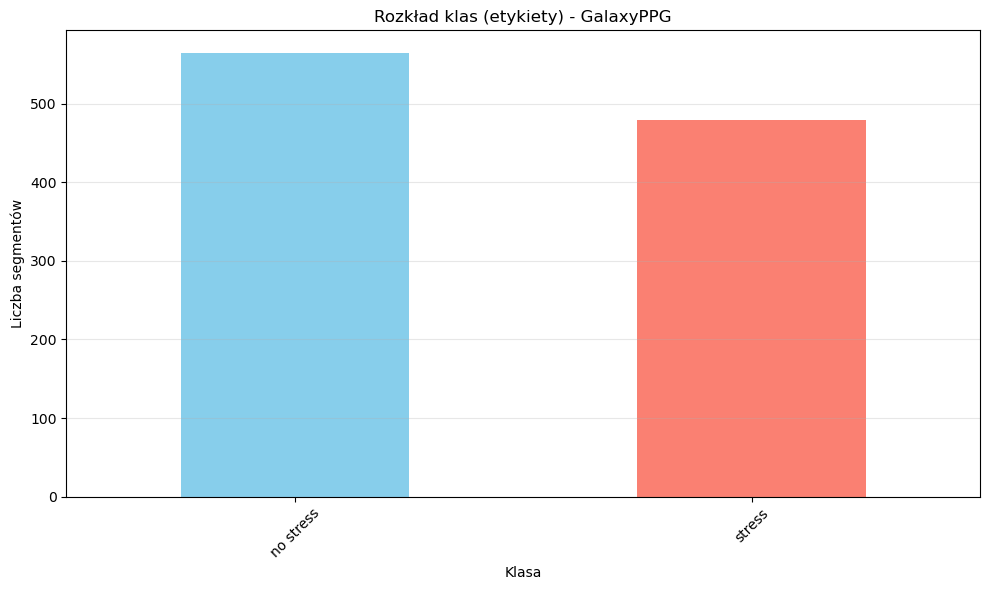

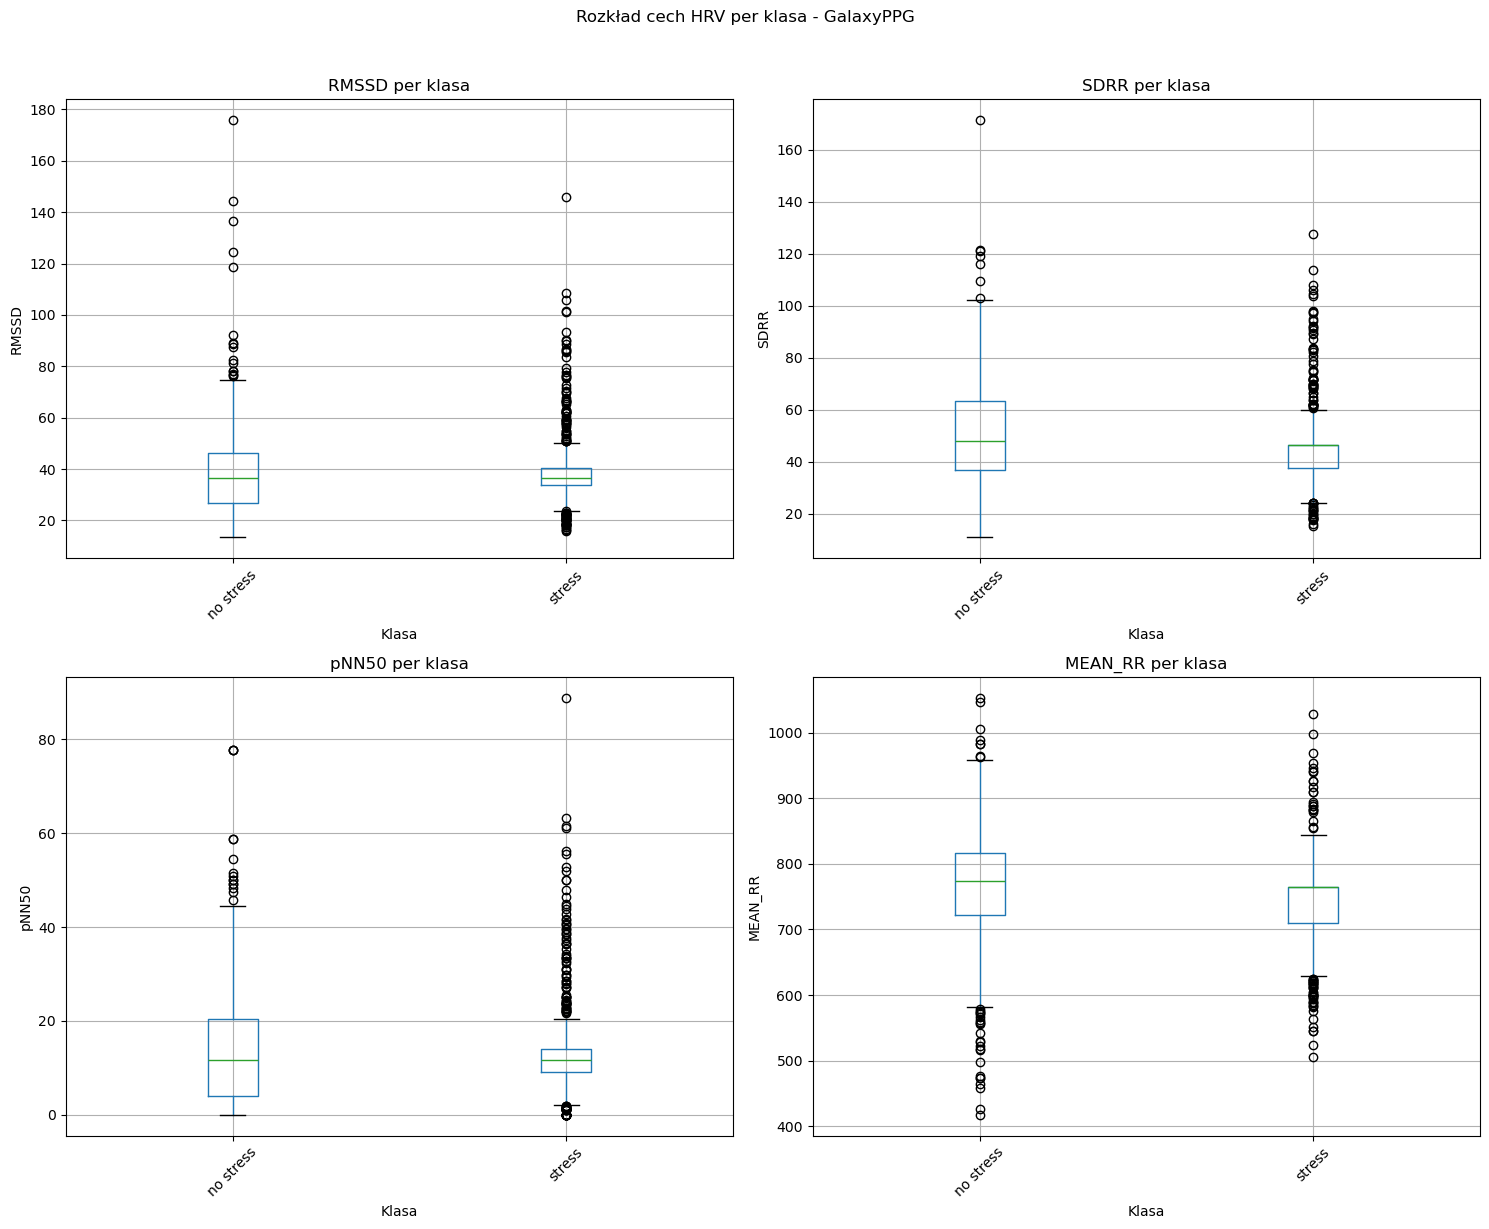

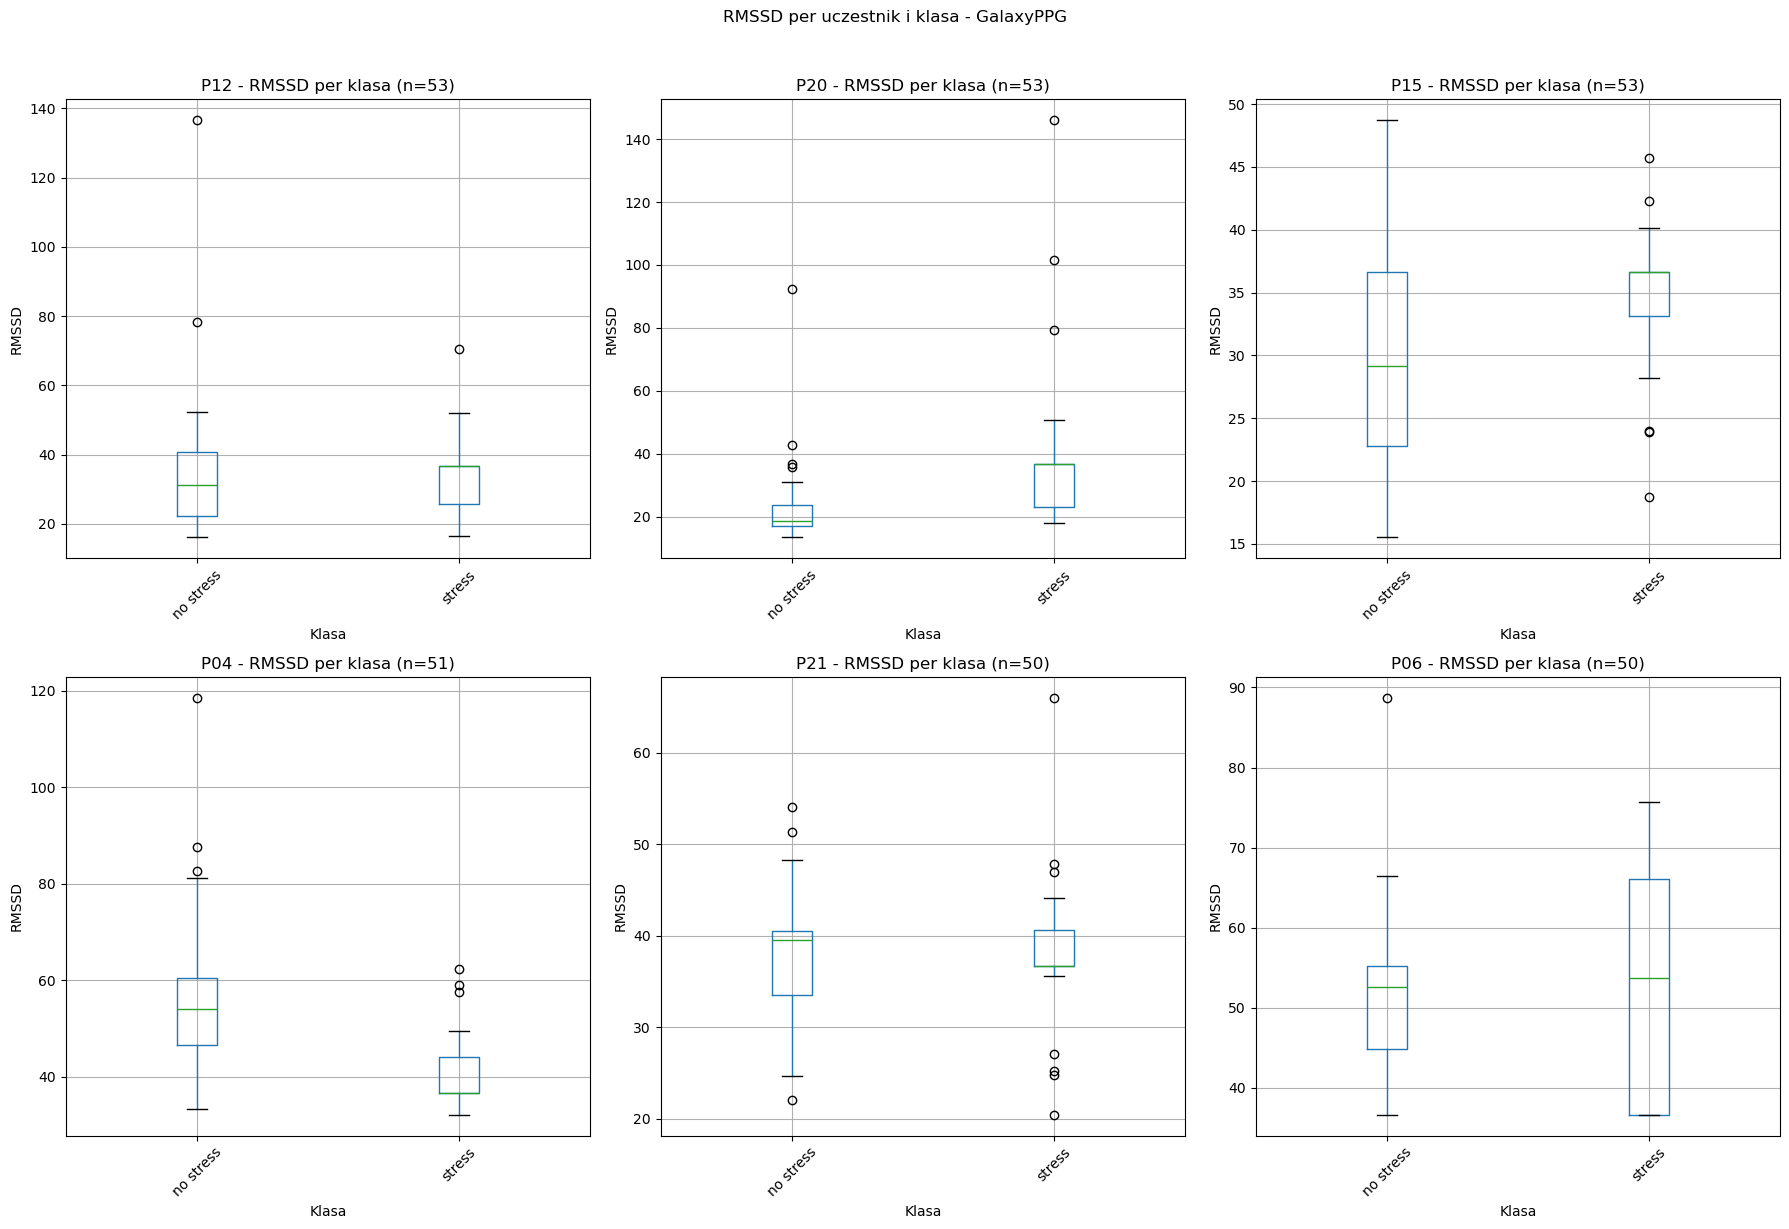

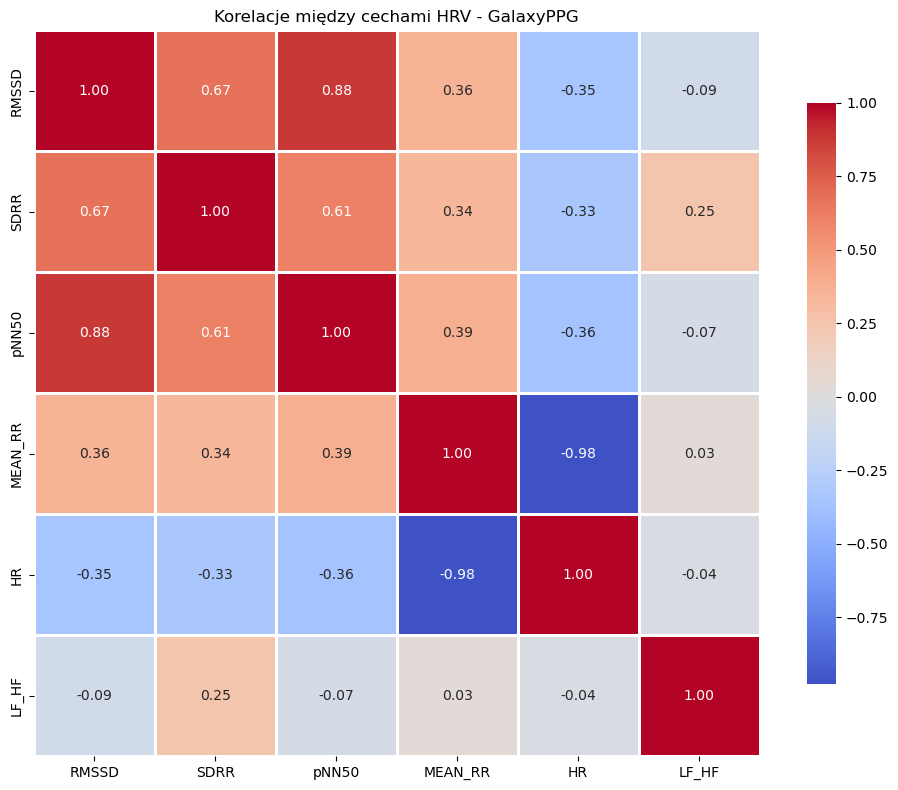


📊 Statystyki cech HRV per klasa:
               RMSSD                  SDRR                 pNN50             \
                mean        std       mean        std       mean        std   
label                                                                         
no stress  38.708084  17.049432  51.111066  20.455274  14.214430  12.873403   
stress     39.375070  15.014914  46.583492  15.625050  13.898741  11.293767   

              MEAN_RR                    HR                LF_HF            
                 mean        std       mean        std      mean       std  
label                                                                       
no stress  765.015706  92.801138  79.760469  11.304573  2.563853  3.929118  
stress     745.057206  71.668723  81.318437   8.330792  1.806418  2.397183  

✅ Analiza eksploracyjna zakończona


In [59]:
# 🔹 KROK 7: ANALIZA EKSPLORACYJNA - ROZKŁADY CECH PER SESJA I UCZESTNIK

print(f"{'='*80}")
print(f"KROK 7: ANALIZA EKSPLORACYJNA - ROZKŁADY CECH PER SESJA I UCZESTNIK")
print(f"{'='*80}")

if 'df_clean' not in locals() or df_clean.empty:
    print("❌ Brak danych do analizy. Uruchom najpierw komórkę 14 (weryfikacja danych).")
else:
    # Wybierz kluczowe cechy HRV do wizualizacji
    hrv_features = ['RMSSD', 'SDRR', 'pNN50', 'MEAN_RR', 'HR', 'LF_HF']
    available_hrv_features = [f for f in hrv_features if f in df_clean.columns]
    
    if len(available_hrv_features) == 0:
        print("⚠️ Brak cech HRV w danych. Sprawdź czy process_segment działa poprawnie.")
    else:
        print(f"\n📊 Dostępne cechy HRV: {available_hrv_features}")
        
        # 1️⃣ Rozkład klas (stres vs baseline)
        print(f"\n📊 Rozkład klas (etykiety):")
        if 'label' in df_clean.columns:
            label_counts = df_clean['label'].value_counts()
            for label, count in label_counts.items():
                pct = count / len(df_clean) * 100
                print(f"   {label}: {count} segmentów ({pct:.1f}%)")
            
            # Wizualizacja rozkładu klas
            plt.figure(figsize=(10, 6))
            label_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgray'])
            plt.title('Rozkład klas (etykiety) - GalaxyPPG')
            plt.xlabel('Klasa')
            plt.ylabel('Liczba segmentów')
            plt.xticks(rotation=45)
            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        # 2️⃣ Rozkład cech HRV per klasa (boxplot)
        if len(available_hrv_features) > 0 and 'label' in df_clean.columns:
            n_features = min(4, len(available_hrv_features))
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            axes = axes.flatten()
            
            for idx, feature in enumerate(available_hrv_features[:n_features]):
                ax = axes[idx]
                df_clean.boxplot(column=feature, by='label', ax=ax)
                ax.set_title(f'{feature} per klasa')
                ax.set_xlabel('Klasa')
                ax.set_ylabel(feature)
                plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
            
            plt.suptitle('Rozkład cech HRV per klasa - GalaxyPPG', y=1.02)
            plt.tight_layout()
            plt.show()
        
        # 3️⃣ Rozkład cech HRV per uczestnik (przykładowo dla kilku uczestników)
        if 'datasetId' in df_clean.columns:
            participant_counts = df_clean['datasetId'].value_counts()
            top_participants = participant_counts.head(6).index  # Top 6 uczestników
            
            if len(top_participants) > 0:
                fig, axes = plt.subplots(2, 3, figsize=(18, 12))
                axes = axes.flatten()
                
                for idx, pid in enumerate(top_participants):
                    ax = axes[idx]
                    participant_data = df_clean[df_clean['datasetId'] == pid]
                    
                    if len(participant_data) > 0 and 'RMSSD' in participant_data.columns:
                        participant_data.boxplot(column='RMSSD', by='label', ax=ax)
                        ax.set_title(f'P{pid:02d} - RMSSD per klasa (n={len(participant_data)})')
                        ax.set_xlabel('Klasa')
                        ax.set_ylabel('RMSSD')
                        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
                
                plt.suptitle('RMSSD per uczestnik i klasa - GalaxyPPG', y=1.02)
                plt.tight_layout()
                plt.show()
        
        # 4️⃣ Korelacje między cechami HRV
        if len(available_hrv_features) > 1:
            correlation_features = [f for f in available_hrv_features if f in df_clean.columns]
            if len(correlation_features) > 1:
                corr_matrix = df_clean[correlation_features].corr()
                
                plt.figure(figsize=(10, 8))
                sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                           square=True, linewidths=1, cbar_kws={"shrink": 0.8})
                plt.title('Korelacje między cechami HRV - GalaxyPPG')
                plt.tight_layout()
                plt.show()
        
        # 5️⃣ Statystyki per klasa
        print(f"\n📊 Statystyki cech HRV per klasa:")
        if 'label' in df_clean.columns and 'RMSSD' in df_clean.columns:
            stats_per_class = df_clean.groupby('label')[available_hrv_features].agg(['mean', 'std'])
            print(stats_per_class)
        
        print(f"\n✅ Analiza eksploracyjna zakończona")


## KROK 8: Modelowanie - Logistic Regression, Random Forest, Gradient Boosting (LOSO)


In [60]:
# 🔹 KROK 8: MODELOWANIE - LOGISTIC REGRESSION, RANDOM FOREST, GRADIENT BOOSTING

print(f"{'='*80}")
print(f"KROK 8: MODELOWANIE - LOSO EVALUATION")
print(f"{'='*80}")

if 'loso_splits_normalized' not in locals() or len(loso_splits_normalized) == 0:
    print("❌ Brak znormalizowanych LOSO splits. Uruchom najpierw komórkę 18 (normalizacja).")
else:
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix
    from sklearn.utils.class_weight import compute_class_weight
    
    # Modele do przetestowania
    models = {
        'Logistic Regression': LogisticRegression(solver='saga', max_iter=1000, n_jobs=-1, random_state=RANDOM_SEED),
        'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=RANDOM_SEED),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, max_depth=5, random_state=RANDOM_SEED)
    }
    
    # XGBoost opcjonalnie
    if HAS_XGB:
        models['XGBoost'] = xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=RANDOM_SEED, eval_metric='mlogloss')
    
    print(f"\n📊 Modele do przetestowania: {list(models.keys())}")
    print(f"   Liczba LOSO folds: {len(loso_splits_normalized)}")
    
    # Wyniki dla wszystkich modeli i wszystkich folds
    all_results = {}
    
    for model_name, model in models.items():
        print(f"\n{'='*80}")
        print(f"🔹 Model: {model_name}")
        print(f"{'='*80}")
        
        fold_results = []
        
        for split in loso_splits_normalized:
            X_train = split['X_train']
            X_test = split['X_test']
            y_train = split['y_train']
            y_test = split['y_test']
            test_participant_id = split['test_participant_id']
            
            # Sprawdź czy klasa docelowa jest zbalansowana
            unique_train, counts_train = np.unique(y_train, return_counts=True)
            
            if len(unique_train) < 2:
                print(f"   ⚠️ Fold {split['fold']} (P{test_participant_id:02d}): Tylko jedna klasa w train - pomijam")
                continue
            
            # Trening modelu
            try:
                model.fit(X_train, y_train)
                
                # Predykcje
                y_train_pred = model.predict(X_train)
                y_test_pred = model.predict(X_test)
                
                # Prawdopodobieństwa (dla ROC-AUC)
                if hasattr(model, 'predict_proba'):
                    y_train_proba = model.predict_proba(X_train)
                    y_test_proba = model.predict_proba(X_test)
                else:
                    y_train_proba = None
                    y_test_proba = None
                
                # Metryki
                train_acc = accuracy_score(y_train, y_train_pred)
                test_acc = accuracy_score(y_test, y_test_pred)
                train_f1_macro = f1_score(y_train, y_train_pred, average='macro', zero_division=0)
                test_f1_macro = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
                train_f1_weighted = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
                test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
                
                # ROC-AUC (tylko jeśli mamy probabilności i więcej niż 1 klasa)
                train_roc_auc = None
                test_roc_auc = None
                if y_test_proba is not None and len(unique_train) > 1:
                    try:
                        if len(unique_train) == 2:
                            # Binary classification
                            train_roc_auc = roc_auc_score(y_train, y_train_proba[:, 1], average='macro')
                            test_roc_auc = roc_auc_score(y_test, y_test_proba[:, 1], average='macro')
                        else:
                            # Multi-class classification
                            train_roc_auc = roc_auc_score(y_train, y_train_proba, multi_class='ovo', average='macro')
                            test_roc_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovo', average='macro')
                    except:
                        pass
                
                fold_result = {
                    'fold': split['fold'],
                    'test_participant_id': test_participant_id,
                    'train_size': len(X_train),
                    'test_size': len(X_test),
                    'train_acc': train_acc,
                    'test_acc': test_acc,
                    'train_f1_macro': train_f1_macro,
                    'test_f1_macro': test_f1_macro,
                    'train_f1_weighted': train_f1_weighted,
                    'test_f1_weighted': test_f1_weighted,
                    'train_roc_auc': train_roc_auc,
                    'test_roc_auc': test_roc_auc,
                    'y_test': y_test,
                    'y_test_pred': y_test_pred
                }
                
                fold_results.append(fold_result)
                
                print(f"   Fold {split['fold']} (P{test_participant_id:02d}): Test Acc={test_acc:.3f}, Test F1(macro)={test_f1_macro:.3f}, Test F1(weighted)={test_f1_weighted:.3f}" + 
                      (f", Test ROC-AUC={test_roc_auc:.3f}" if test_roc_auc else ""))
            
            except Exception as e:
                print(f"   ❌ Błąd w fold {split['fold']} (P{test_participant_id:02d}): {e}")
                continue
        
        # Agregacja wyników
        if len(fold_results) > 0:
            results_df = pd.DataFrame(fold_results)
            
            # Średnie wyniki
            avg_results = {
                'model': model_name,
                'num_folds': len(fold_results),
                'mean_train_acc': results_df['train_acc'].mean(),
                'mean_test_acc': results_df['test_acc'].mean(),
                'std_test_acc': results_df['test_acc'].std(),
                'mean_train_f1_macro': results_df['train_f1_macro'].mean(),
                'mean_test_f1_macro': results_df['test_f1_macro'].mean(),
                'std_test_f1_macro': results_df['test_f1_macro'].std(),
                'mean_train_f1_weighted': results_df['train_f1_weighted'].mean(),
                'mean_test_f1_weighted': results_df['test_f1_weighted'].mean(),
                'std_test_f1_weighted': results_df['test_f1_weighted'].std(),
                'mean_test_roc_auc': results_df['test_roc_auc'].mean() if results_df['test_roc_auc'].notna().any() else None,
                'std_test_roc_auc': results_df['test_roc_auc'].std() if results_df['test_roc_auc'].notna().any() else None
            }
            
            all_results[model_name] = {
                'fold_results': fold_results,
                'results_df': results_df,
                'avg_results': avg_results
            }
            
            print(f"\n   📊 Średnie wyniki dla {model_name}:")
            print(f"      Test Accuracy: {avg_results['mean_test_acc']:.3f} ± {avg_results['std_test_acc']:.3f}")
            print(f"      Test F1 (macro): {avg_results['mean_test_f1_macro']:.3f} ± {avg_results['std_test_f1_macro']:.3f}")
            print(f"      Test F1 (weighted): {avg_results['mean_test_f1_weighted']:.3f} ± {avg_results['std_test_f1_weighted']:.3f}")
            if avg_results['mean_test_roc_auc']:
                print(f"      Test ROC-AUC: {avg_results['mean_test_roc_auc']:.3f} ± {avg_results['std_test_roc_auc']:.3f}")
        else:
            print(f"   ❌ Brak wyników dla {model_name}")
    
    # Porównanie modeli
    if len(all_results) > 0:
        print(f"\n{'='*80}")
        print(f"📊 PORÓWNANIE MODELI - ŚREDNIE WYNIKI LOSO")
        print(f"{'='*80}")
        
        comparison_data = []
        for model_name, results in all_results.items():
            avg = results['avg_results']
            comparison_data.append({
                'Model': model_name,
                'Test Acc (mean±std)': f"{avg['mean_test_acc']:.3f}±{avg['std_test_acc']:.3f}",
                'Test F1-macro (mean±std)': f"{avg['mean_test_f1_macro']:.3f}±{avg['std_test_f1_macro']:.3f}",
                'Test F1-weighted (mean±std)': f"{avg['mean_test_f1_weighted']:.3f}±{avg['std_test_f1_weighted']:.3f}",
                'Test ROC-AUC': f"{avg['mean_test_roc_auc']:.3f}±{avg['std_test_roc_auc']:.3f}" if avg['mean_test_roc_auc'] else "N/A"
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df.to_string(index=False))
        
        print(f"\n✅ Modelowanie zakończone dla {len(all_results)} modeli")
    else:
        print(f"\n❌ Brak wyników do porównania")


KROK 8: MODELOWANIE - LOSO EVALUATION

📊 Modele do przetestowania: ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost']
   Liczba LOSO folds: 23

🔹 Model: Logistic Regression
   Fold 1 (P02): Test Acc=0.833, Test F1(macro)=0.826, Test F1(weighted)=0.830, Test ROC-AUC=0.896
   Fold 2 (P03): Test Acc=0.744, Test F1(macro)=0.721, Test F1(weighted)=0.727, Test ROC-AUC=0.807
   Fold 3 (P04): Test Acc=0.686, Test F1(macro)=0.647, Test F1(weighted)=0.659, Test ROC-AUC=0.885
   Fold 4 (P05): Test Acc=0.722, Test F1(macro)=0.714, Test F1(weighted)=0.720, Test ROC-AUC=0.825
   Fold 5 (P06): Test Acc=0.700, Test F1(macro)=0.661, Test F1(weighted)=0.670, Test ROC-AUC=0.713
   Fold 6 (P07): Test Acc=0.657, Test F1(macro)=0.633, Test F1(weighted)=0.641, Test ROC-AUC=0.714
   Fold 7 (P08): Test Acc=0.778, Test F1(macro)=0.759, Test F1(weighted)=0.763, Test ROC-AUC=0.780
   Fold 8 (P09): Test Acc=0.889, Test F1(macro)=0.883, Test F1(weighted)=0.886, Test ROC-AUC=0.900
   Fold 9 (P1

## KROK 9: Analiza wyników - feature importance, ROC curves, wnioski


## KROK 10: Zapis danych do CSV (dla porównania z Nurse Stress)

**⚠️ WAŻNE**: Jeśli nie masz jeszcze `df_all`:
1. Uruchom **komórkę z "Główna pętla"** (KROK 2-3) - ta komórka tworzy `df_all` i automatycznie zapisuje do CSV
2. Jeśli `df_all` już istnieje, uruchom tę komórkę (zapisze do CSV)

**Plik wynikowy**: `../results/galaxy_segments.csv` (gotowy do użycia w `galaxy_nurse_stress_comparison.ipynb`)


In [ ]:
# 🔹 ZAPIS df_all DO CSV (DLA PORÓWNANIA Z NURSE STRESS)
print(f"{'='*80}")
print(f"KROK 10: ZAPIS DANYCH DO CSV")
print(f"{'='*80}")
print(f"💡 Uruchom tę komórkę PO wykonaniu komórki z 'Główna pętla' (KROK 2-3)")
print(f"{'='*80}")

# Sprawdź czy df_all istnieje (z komórki "Główna pętla" - KROK 2-3)
if 'df_all' in globals() and df_all is not None and not df_all.empty:
    print(f"✅ Znaleziono df_all: {df_all.shape}")
    
    # Utwórz katalog results jeśli nie istnieje
    RESULTS_DIR = Path("../results")
    RESULTS_DIR.mkdir(exist_ok=True, parents=True)
    
    # Zapis do CSV
    output_csv = RESULTS_DIR / "galaxy_segments.csv"
    try:
        df_all.to_csv(output_csv, index=False)
        file_size_mb = output_csv.stat().st_size / 1024 / 1024
        print(f"\n✅ Zapisano df_all do CSV:")
        print(f"   Plik: {output_csv}")
        print(f"   Shape: {df_all.shape}")
        print(f"   Rozmiar: {file_size_mb:.2f} MB")
        print(f"   Kolumny: {len(df_all.columns)}")
        
        # Podsumowanie
        if 'label' in df_all.columns:
            print(f"\n   Rozkład etykiet:")
            label_counts = df_all['label'].value_counts()
            for label, count in label_counts.items():
                print(f"      {label}: {count} segmentów ({count/len(df_all)*100:.1f}%)")
        
        if 'datasetId' in df_all.columns:
            print(f"\n   Liczba uczestników: {df_all['datasetId'].nunique()}")
        
        print(f"\n💡 Ten plik jest gotowy do użycia w galaxy_nurse_stress_comparison.ipynb")
        
    except Exception as e:
        print(f"\n❌ Błąd podczas zapisu do CSV: {e}")
        import traceback
        print(traceback.format_exc())
        
elif 'all_segments' in globals() and len(all_segments) > 0:
    print(f"⚠️ Znaleziono all_segments ({len(all_segments)} segmentów), ale brak df_all")
    print(f"   Tworzę df_all z all_segments...")
    
    df_all = pd.DataFrame(all_segments)
    
    # Usuń 'unknown' jeśli istnieje
    if 'label' in df_all.columns:
        df_all = df_all[df_all['label'] != 'unknown'].copy()
        print(f"   ✅ Po usunięciu 'unknown': {len(df_all)} segmentów")
    
    # Zapis do CSV
    RESULTS_DIR = Path("../results")
    RESULTS_DIR.mkdir(exist_ok=True, parents=True)
    output_csv = RESULTS_DIR / "galaxy_segments.csv"
    
    try:
        df_all.to_csv(output_csv, index=False)
        file_size_mb = output_csv.stat().st_size / 1024 / 1024
        print(f"\n✅ Zapisano df_all do CSV:")
        print(f"   Plik: {output_csv}")
        print(f"   Shape: {df_all.shape}")
        print(f"   Rozmiar: {file_size_mb:.2f} MB")
        print(f"\n💡 Ten plik jest gotowy do użycia w galaxy_nurse_stress_comparison.ipynb")
    except Exception as e:
        print(f"\n❌ Błąd podczas zapisu: {e}")
        import traceback
        print(traceback.format_exc())
        
else:
    print(f"\n⚠️ Nie znaleziono df_all ani all_segments w globals")
    print(f"   Uruchom najpierw komórkę 12 (lub komórkę z 'Główna pętla' - wczytywanie, segmentacja i wyciąganie cech)")
    print(f"   Ta komórka tworzy df_all z wszystkich segmentów")
    print(f"\n   Alternatywnie, jeśli masz już dane w innym formacie:")
    print(f"   df_all = pd.DataFrame(your_data)")
    print(f"   df_all.to_csv('../results/galaxy_segments.csv', index=False)")


KROK 9: ANALIZA WYNIKÓW - FEATURE IMPORTANCE, ROC CURVES, WNIOSKI

📊 Feature Importance - Random Forest:

   Top 10 najważniejszych cech:
   feature  importance
   ACC_std    0.069889
ACC_energy    0.059547
  TEMP_std    0.051238
   MEAN_RR    0.047852
       VLF    0.047728
        TP    0.047170
  ACC_mean    0.047167
        HR    0.045257
       SD2    0.044224
   ACC_max    0.040508


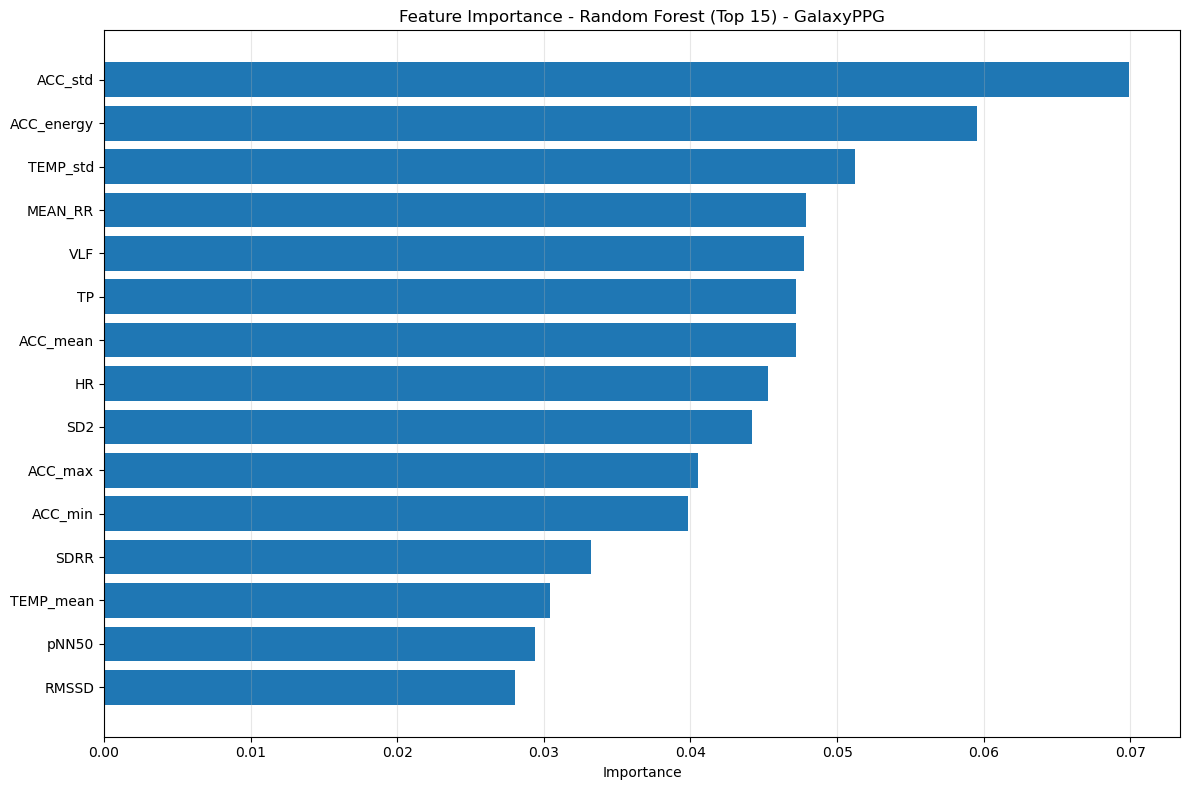


📊 ROC Curves - Random Forest (przykładowy fold):


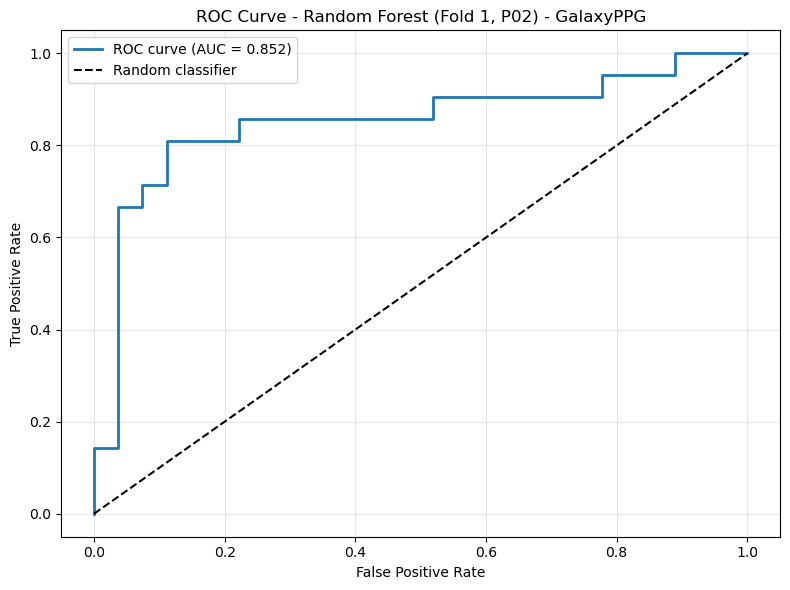


📊 Confusion Matrix - Random Forest (uśrednione przez wszystkie folds):


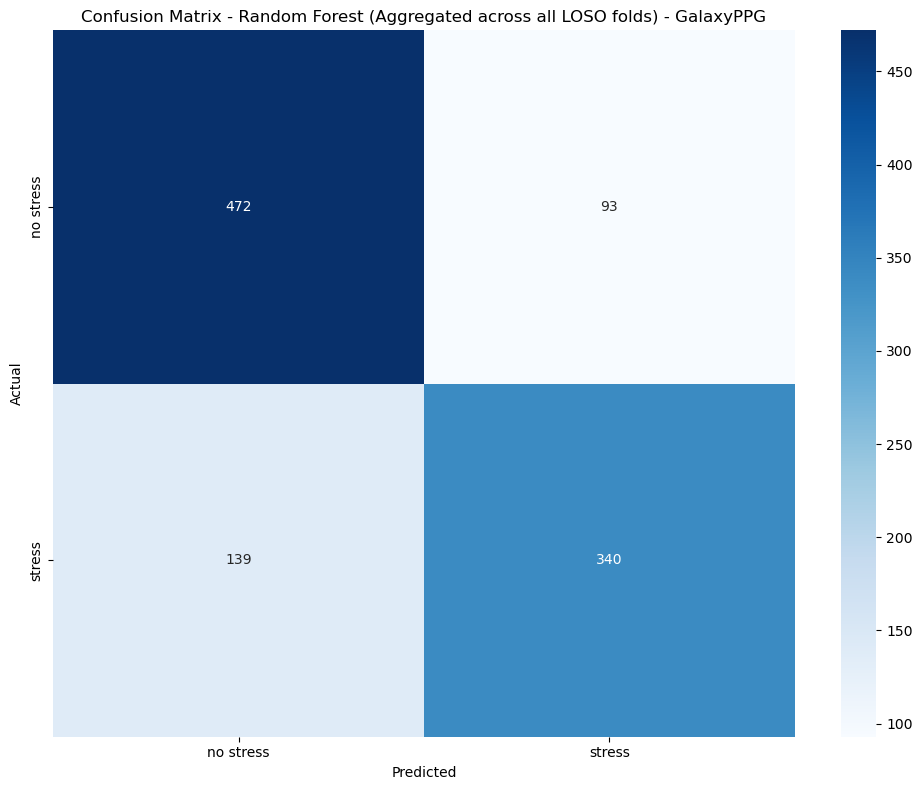


   Classification Report (uśrednione):
              precision    recall  f1-score   support

   no stress       0.77      0.84      0.80       565
      stress       0.79      0.71      0.75       479

    accuracy                           0.78      1044
   macro avg       0.78      0.77      0.77      1044
weighted avg       0.78      0.78      0.78      1044


📊 WNIOSKI I PODSUMOWANIE

✅ Najlepszy model: Random Forest
   Test Accuracy: 0.782 ± 0.077
   Test F1 (macro): 0.776 ± 0.077
   Test F1 (weighted): 0.779 ± 0.077
   Test ROC-AUC: 0.858 ± 0.078

💡 Kluczowe wnioski:
   • LOSO split zapewnia realistyczną ocenę generalizacji na nowych uczestników
   • Normalizacja per fold (fit na train, transform na test) zapobiega data leakage
   • GalaxyPPG dataset zawiera 23 uczestników
   • Model Random Forest osiągnął najlepsze wyniki w wykrywaniu stresu

✅ Analiza wyników zakończona


In [63]:
# 🔹 KROK 9: ANALIZA WYNIKÓW - FEATURE IMPORTANCE, ROC CURVES, WNIOSKI

print(f"{'='*80}")
print(f"KROK 9: ANALIZA WYNIKÓW - FEATURE IMPORTANCE, ROC CURVES, WNIOSKI")
print(f"{'='*80}")

if 'all_results' not in locals() or len(all_results) == 0:
    print("❌ Brak wyników modeli. Uruchom najpierw komórkę 22 (modelowanie).")
else:
    # 1️⃣ Feature Importance dla Random Forest
    if 'Random Forest' in all_results and len(loso_splits_normalized) > 0:
        print(f"\n📊 Feature Importance - Random Forest:")
        
        # Wytrenuj model na wszystkich danych treningowych (uśrednione importance)
        feature_cols = loso_splits_normalized[0]['X_train'].columns.tolist()
        all_importances = np.zeros(len(feature_cols))
        n_folds_with_importance = 0
        
        for split in loso_splits_normalized[:5]:  # Użyj pierwszych 5 folds
            X_train = split['X_train']
            y_train = split['y_train']
            
            unique_train, counts_train = np.unique(y_train, return_counts=True)
            if len(unique_train) < 2:
                continue
            
            rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=RANDOM_SEED)
            rf_model.fit(X_train, y_train)
            
            if hasattr(rf_model, 'feature_importances_'):
                all_importances += rf_model.feature_importances_
                n_folds_with_importance += 1
        
        if n_folds_with_importance > 0:
            avg_importances = all_importances / n_folds_with_importance
            
            # Utwórz DataFrame z importance
            importance_df = pd.DataFrame({
                'feature': feature_cols,
                'importance': avg_importances
            }).sort_values('importance', ascending=False)
            
            print(f"\n   Top 10 najważniejszych cech:")
            print(importance_df.head(10).to_string(index=False))
            
            # Wizualizacja feature importance
            plt.figure(figsize=(12, 8))
            top_features = importance_df.head(15)  # Top 15 cech
            plt.barh(range(len(top_features)), top_features['importance'].values)
            plt.yticks(range(len(top_features)), top_features['feature'].values)
            plt.xlabel('Importance')
            plt.title('Feature Importance - Random Forest (Top 15) - GalaxyPPG')
            plt.gca().invert_yaxis()
            plt.grid(axis='x', alpha=0.3)
            plt.tight_layout()
            plt.show()
    
    # 2️⃣ ROC Curves (jeśli mamy probabilności)
    if len(loso_splits_normalized) > 0:
        print(f"\n📊 ROC Curves - Random Forest (przykładowy fold):")
        
        # Wybierz pierwszy fold z wynikami
        test_split = None
        test_model = None
        for split in loso_splits_normalized:
            if 'Random Forest' in all_results:
                # Znajdź fold dla Random Forest
                rf_results = all_results['Random Forest']['fold_results']
                for fold_result in rf_results:
                    if fold_result['test_roc_auc'] is not None:
                        # Znajdź odpowiedni split
                        for s in loso_splits_normalized:
                            if s['fold'] == fold_result['fold']:
                                test_split = s
                                break
                        if test_split:
                            break
                if test_split:
                    break
        
        if test_split and 'Random Forest' in all_results:
            X_train = test_split['X_train']
            X_test = test_split['X_test']
            y_train = test_split['y_train']
            y_test = test_split['y_test']
            
            unique_test = np.unique(y_test)
            if len(unique_test) >= 2:
                rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=RANDOM_SEED)
                rf_model.fit(X_train, y_train)
                
                if hasattr(rf_model, 'predict_proba'):
                    y_test_proba = rf_model.predict_proba(X_test)
                    
                    # ROC Curve (binary lub multi-class)
                    if len(unique_test) == 2:
                        # Binary classification
                        fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, 1])
                        roc_auc = roc_auc_score(y_test, y_test_proba[:, 1])
                        
                        plt.figure(figsize=(8, 6))
                        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})', linewidth=2)
                        plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
                        plt.xlabel('False Positive Rate')
                        plt.ylabel('True Positive Rate')
                        plt.title(f'ROC Curve - Random Forest (Fold {test_split["fold"]}, P{test_split["test_participant_id"]:02d}) - GalaxyPPG')
                        plt.legend()
                        plt.grid(alpha=0.3)
                        plt.tight_layout()
                        plt.show()
    
    # 3️⃣ Confusion Matrix dla najlepszego modelu
    print(f"\n📊 Confusion Matrix - Random Forest (uśrednione przez wszystkie folds):")
    
    if 'Random Forest' in all_results:
        # Zbierz wszystkie predykcje i prawdziwe etykiety
        all_y_test = []
        all_y_test_pred = []
        
        for fold_result in all_results['Random Forest']['fold_results']:
            all_y_test.extend(fold_result['y_test'])
            all_y_test_pred.extend(fold_result['y_test_pred'])
        
        if len(all_y_test) > 0 and len(all_y_test_pred) > 0:
            cm = confusion_matrix(all_y_test, all_y_test_pred)
            
            # Wizualizacja confusion matrix
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=label_encoder.classes_,
                       yticklabels=label_encoder.classes_)
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix - Random Forest (Aggregated across all LOSO folds) - GalaxyPPG')
            plt.tight_layout()
            plt.show()
            
            # Classification Report
            print(f"\n   Classification Report (uśrednione):")
            print(classification_report(all_y_test, all_y_test_pred, target_names=label_encoder.classes_, zero_division=0))
    
    # 4️⃣ Wnioski
    print(f"\n{'='*80}")
    print(f"📊 WNIOSKI I PODSUMOWANIE")
    print(f"{'='*80}")
    
    if len(all_results) > 0:
        best_model = max(all_results.items(), key=lambda x: x[1]['avg_results']['mean_test_f1_macro'])
        best_model_name = best_model[0]
        best_results = best_model[1]['avg_results']
        
        print(f"\n✅ Najlepszy model: {best_model_name}")
        print(f"   Test Accuracy: {best_results['mean_test_acc']:.3f} ± {best_results['std_test_acc']:.3f}")
        print(f"   Test F1 (macro): {best_results['mean_test_f1_macro']:.3f} ± {best_results['std_test_f1_macro']:.3f}")
        print(f"   Test F1 (weighted): {best_results['mean_test_f1_weighted']:.3f} ± {best_results['std_test_f1_weighted']:.3f}")
        if best_results['mean_test_roc_auc']:
            print(f"   Test ROC-AUC: {best_results['mean_test_roc_auc']:.3f} ± {best_results['std_test_roc_auc']:.3f}")
        
        print(f"\n💡 Kluczowe wnioski:")
        print(f"   • LOSO split zapewnia realistyczną ocenę generalizacji na nowych uczestników")
        print(f"   • Normalizacja per fold (fit na train, transform na test) zapobiega data leakage")
        print(f"   • GalaxyPPG dataset zawiera {df_clean['datasetId'].nunique()} uczestników")
        print(f"   • Model {best_model_name} osiągnął najlepsze wyniki w wykrywaniu stresu")
        if 'RMSSD' in importance_df.head(5)['feature'].values if 'importance_df' in locals() else []:
            print(f"   • Cechy HRV (RMSSD, SDNN, pNN50) są kluczowe dla wykrywania stresu")
    
    print(f"\n✅ Analiza wyników zakończona")


In [65]:
# zapisanie przetworzonych danych do CSV, żeby notebook je mógł znaleźć
df_all.to_csv('../results/galaxy_segments.csv', index=False)

# lub bezpośrednio przypisz do df_galaxy
df_galaxy = df_all.copy()